# Singole Nazioni

Dati delle singole nazioni.

> Max Pierini

Dati cumulativi, variazioni ed $R_t$ di tutte le nazioni coinvolte.

***

Legenda:

- Cumulativi e Variazioni
    - Rosso: deceduti
    - Verde: guariti
    - Blu: positivi
    - Nero: casi totali

- $R_t$ numero di riproduzione effettivo
    - Rosso: maggiore di 1
    - Verde: minore di 1
    
- metodo EpiEstim implementato in `python` (vedi [Stima Rt e previsioni](https://www.epidata.it/Italia/stime_Rt.html))

> NB: gli $R_t$ stimati da EpiDataItalia sono parametrizzati attualmente sui <u>soli nuovi casi</u> e **non sono sovrapponibili al numero di riproduzione stimato da ISS-EpiCentro** che utilizza lo stesso modello *EpiEstim* ([A new framework and software to estimate time-varying reproduction numbers during epidemics, Cori-Ferguson-Fraser 2013](https://doi.org/10.1093/aje/kwt133)) ma con dati aggiuntivi attualmente **non disponibili al pubblico** (il numero di casi sintomatici con data di inizio sintomi, il numero di casi sintomatici importati da un’altra regione o dall’estero). Per info sul modello in uso da ISS-EpiCentro consultare la pagina [FAQ sul calcolo del Rt](https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/faq-sul-calcolo-del-rt) di ISS. Per chiedere al Governo l'accesso pubblico a tutti i dati grezzi disaggregati di COVID-19 in Italia consigliamo l'adesione alla **[Petizione DatiBeneComune](https://datibenecomune.it)**.

In [1]:
import datetime as dt

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#from matplotlib.dates import date2num, num2date
#from matplotlib import dates as mdates
#import matplotlib.ticker as mtick

from IPython.display import Markdown, display, Math
import pandas as pd

#import arviz as az
#import pyjags

import scipy.stats as sps

sns.set()

In [2]:
T = pd.read_csv(
    "https://raw.githubusercontent.com/maxdevblock/covid-19-time-series/master/csv/COVID-Confirmed.csv",
    index_col=["Country/Region"]
).sort_index()
R = pd.read_csv(
    "https://raw.githubusercontent.com/maxdevblock/covid-19-time-series/master/csv/COVID-Recovered.csv",
    index_col=["Country/Region"]
).sort_index()
D = pd.read_csv(
    "https://raw.githubusercontent.com/maxdevblock/covid-19-time-series/master/csv/COVID-Deaths.csv",
    index_col=["Country/Region"]
).sort_index()

In [3]:
T.drop(['Province/State', "Lat", 'Long'], 1, inplace=True)
R.drop(['Province/State', "Lat", 'Long'], 1, inplace=True)
D.drop(['Province/State', "Lat", 'Long'], 1, inplace=True)

In [4]:
T = T.transpose()
T.index = pd.to_datetime(T.index, infer_datetime_format=True)

R = R.transpose()
R.index = pd.to_datetime(R.index, infer_datetime_format=True)

D = D.transpose()
D.index = pd.to_datetime(D.index, infer_datetime_format=True)

days = T.index  #pd.to_datetime(T.columns.values, infer_datetime_format=True)
countries = T.columns.unique().sort_values()  #T.index.get_level_values('Country/Region').unique().sort_values()

In [5]:
display(Markdown(f"""
***

**!! NOTA BENE !!**

- In questa pagina sono visualizzati i grafici di tutte le **{countries.size} nazioni** coinvolte. 
Il caricamento può essere molto lento.

***
"""))


***

**!! NOTA BENE !!**

- In questa pagina sono visualizzati i grafici di tutte le **191 nazioni** coinvolte. 
Il caricamento può essere molto lento.

***


In [6]:
SI_sh_ISS = 1.87
SI_ra_ISS = 0.28

def gamma_mu_sd_from_shape_rate(shape, rate):
    mu = shape / rate
    sd = np.sqrt(shape) / rate
    return mu, sd

def overall_infectivity(incid, SI_y):
    T = incid.size
    _lambda = np.zeros(T)
    _lambda[0] = np.nan
    for t in range(T):
        if not t:
            continue
        _lambda[t] = np.sum(
            SI_y[:t+1] * 
            incid[:t+1][::-1]
        )
    return _lambda

def posterior_from_si_distr(incid, SI_y, a_prior, b_prior, t_start, t_end):
    nb_time_periods = t_start.size
    _lambda = overall_infectivity(incid, SI_y)
    final_mean_si = np.sum(
        SI_y * np.arange(0, SI_y.size, 1)
    )
    a_posterior = np.zeros(shape=nb_time_periods)
    b_posterior = np.zeros(shape=nb_time_periods)
    for t in range(nb_time_periods):
        incid_sum = np.sum(incid[t_start[t]:t_end[t]+1])
        lambda_sum = np.sum(_lambda[t_start[t]:t_end[t]+1])
        if t_end[t] > final_mean_si and incid_sum > 25:
            a_posterior[t] = a_prior + incid_sum
            b_posterior[t] = 1 / (1 / b_prior + lambda_sum)
        else:
            a_posterior[t] = .01
            b_posterior[t] = 1
    return a_posterior, b_posterior, lambda_sum

def epi_estim_Rt(df,
                 SI_mu=None, SI_sd=None,
                 SI_sh=None, SI_ra=None,
                 mu_prior=5, sd_prior=5,
                 CI=.99,
                 plot_incidence=False,
                 plot_Rt=True,
                 ax=None,
                 plot_SI=False,
                 plot_infectivity=False,
                 title='RESULTS',
                 window=14):
    
    cond1 = SI_mu is None and SI_sd is None
    cond2 = SI_sh is None and SI_ra is None
    
    if cond1 and cond2:
        raise Exception('Either SI_mu, SI_sd or SI_sh, SI_ra must be provided.')
    
    df = df.copy(deep=True)
    
    df.columns = ['incidence']
    incid = df.values.ravel()
    idx = df.index
    
    if plot_incidence:
        ax = df.plot(lw=1, color='k', alpha=.75, figsize=(12, 4))
        zero_incidence = df[df==0]
        if zero_incidence.size:
            ax.plot(zero_incidence, marker='o', ls='none', color='b', label='zero new cases')
        less_incidence = df[df<0]
        if less_incidence.size:
            ax.plot(less_incidence, marker='s', ls='none', color='r',label='less than zero')
        ax.legend()
        ax.set(
            title=f'{title} observed incidence'
        )
        plt.show()
    
    less_than_zero = incid < 0
    if less_than_zero.sum():
        print('WARNING: negative values in incidence. Forcing to NaN. Values will be imputed.')
        df.loc[df.incidence<0, 'incidence'] = np.nan
    
    nans = np.isnan(incid).sum()
    if nans:
        print('WARNING: NaN values in incidence. Imputing values with ffill method...')
        df.fillna(method='ffill', inplace=True)
        incid = df.values.ravel()
    
    # quantiles for confidence window
    q1 = (1 - CI) / 2
    q2 = 1 - q1
    
    if SI_mu is None:
        SI_mu, SI_sd = gamma_mu_sd_from_shape_rate(SI_sh, SI_ra)
    
    # calculate discretized serial window distribution
    SI_dist = sps.gamma(a=SI_sh, scale=1/SI_ra)
    SI_x_min = 0
    SI_x_max = int(SI_dist.ppf(.999))
    SI_mu = SI_dist.stats(moments='m')
    SI_x = np.linspace(SI_x_min, SI_x_max, SI_x_max+1)
    SI_y = SI_dist.pdf(SI_x)
    # pad SI with zeros
    SI_tot = np.concatenate((SI_y, np.zeros(incid.size - SI_y.size)))
    
    if plot_SI:
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.bar(SI_x, SI_y, alpha=.5)
        ax.axvline(SI_mu, color='r', ls='--')
        ax.set(
            title=f'{title} Serial Interval: $\mu={SI_mu:.1f}$, $\sigma={SI_sd:.1f}$, '+\
                  f'shape={SI_sh:.3f}, rate={SI_ra:.3f}'
        )
        plt.show()
    
    # calculate shape and scale Rt priors
    a_prior = (mu_prior / sd_prior) ** 2
    b_prior = (sd_prior ** 2) / mu_prior
    
    # length of all observations
    T = incid.size
    
    # start and end of posteriors
    t_start = np.arange(1, T - (window - 1), 1)
    t_end = t_start + (window - 1)
    
    # calculate a and b posteriors
    a_posterior, b_posterior, lambda_sum = posterior_from_si_distr(
        incid, SI_tot, a_prior, b_prior, t_start, t_end)

    # mean of Rt posteriors
    mean_posterior = a_posterior * b_posterior

    # standard deviation of Rt posteriors
    std_posterior = np.sqrt(a_posterior) * b_posterior

    # lower quantile of Rt posterior
    quantile_lo_posterior = sps.gamma.ppf(q1,
      a=a_posterior,
      scale=b_posterior
    )
    # higher quantile of Rt posterior
    quantile_hi_posterior = sps.gamma.ppf(q2,
      a=a_posterior,
      scale=b_posterior
    )
    
    res_index = idx[window:]
    res = pd.DataFrame({
        'date': res_index,
        'R': mean_posterior,
        'std': std_posterior,
        f'q_{q1:.2%}': quantile_lo_posterior,
        f'q_{q2:.2%}': quantile_hi_posterior,
    })
    res.set_index('date', inplace=True)
    
    if plot_Rt:    
        res.plot(
            y='R', color='w', alpha=.1, lw=1, ylim=(0, 5),
            ax=ax
        )

        ax.fill_between(
            res.index, 
            np.where(quantile_hi_posterior<1, quantile_hi_posterior, 1), 
            np.where(quantile_lo_posterior<1, quantile_lo_posterior, 1), 
            alpha=1, color='C2', label='lower than 1')

        ax.fill_between(
            res.index, 
            np.where(quantile_hi_posterior>1, quantile_hi_posterior, 1), 
            np.where(quantile_lo_posterior>1, quantile_lo_posterior, 1), 
            alpha=1, color='C3', label='higher than 1')

        ax.set(
            title=f'{title}: Rt (C.I. {CI:.0%})',
            ylim=(0, 5),
            xlim=(idx[0], idx[-1]),
            ylabel='Rt'
        )
        ax.tick_params(axis='y', which='both', labelleft='on', labelright='on')
        #ax.legend(False)

        ax.axhline(1, color='k', ls='-')
        #plt.show()
    
    return res

## Afghanistan

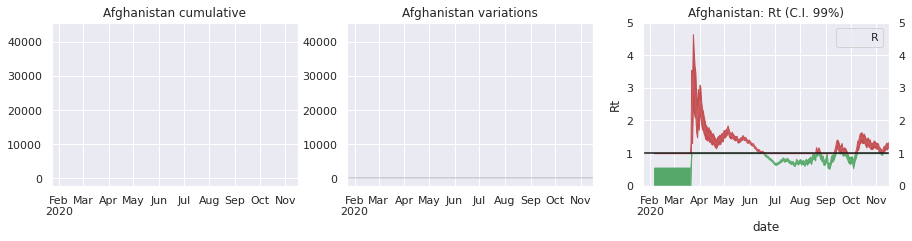

***

## Albania

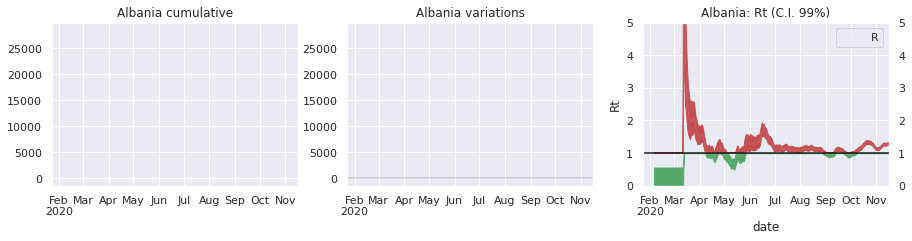

***

## Algeria

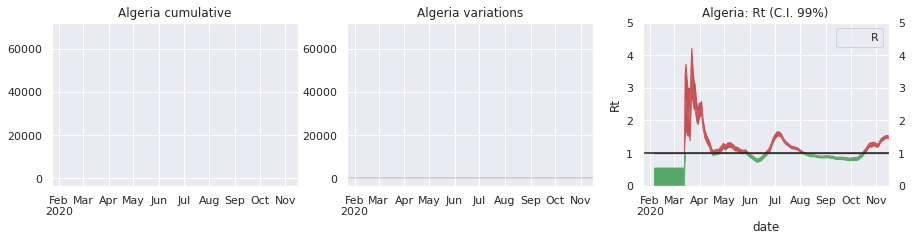

***

## Andorra

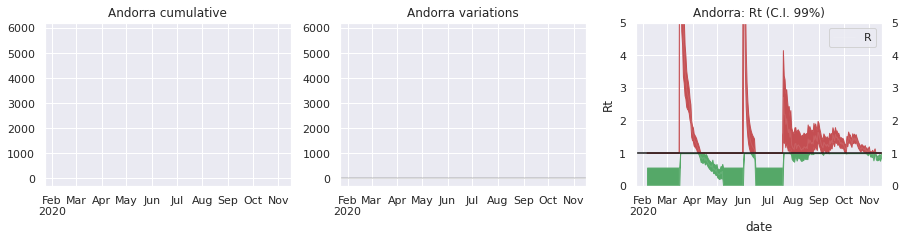

***

## Angola

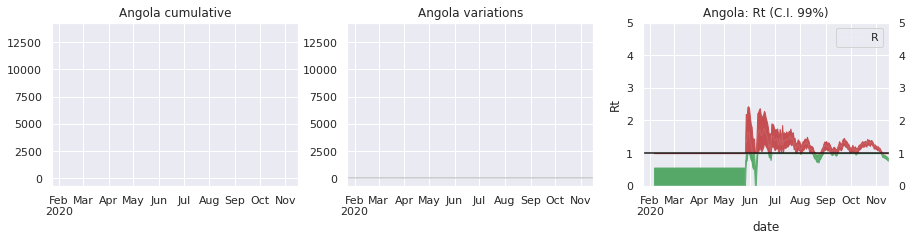

***

## Antigua and Barbuda

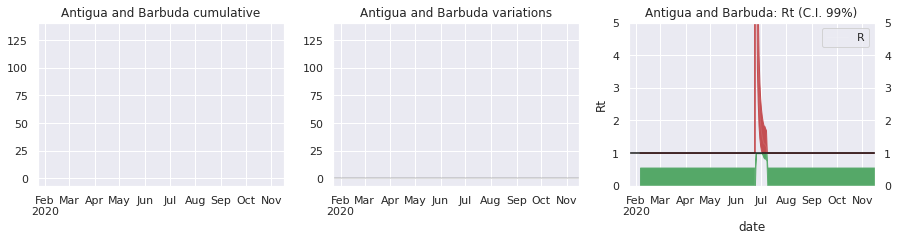

***

## Argentina

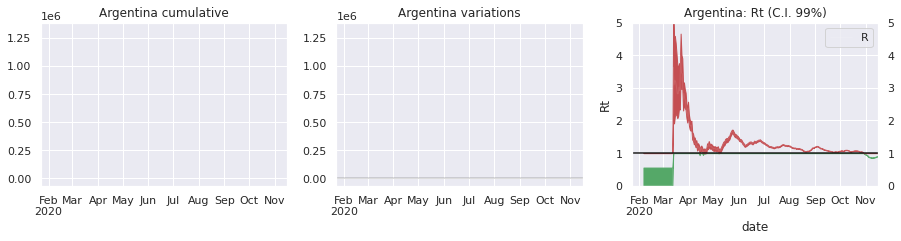

***

## Armenia

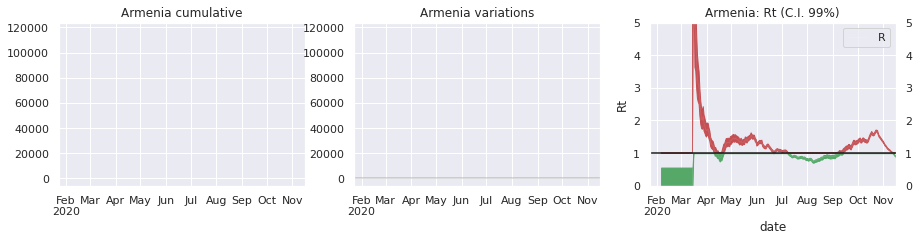

***

## Australia

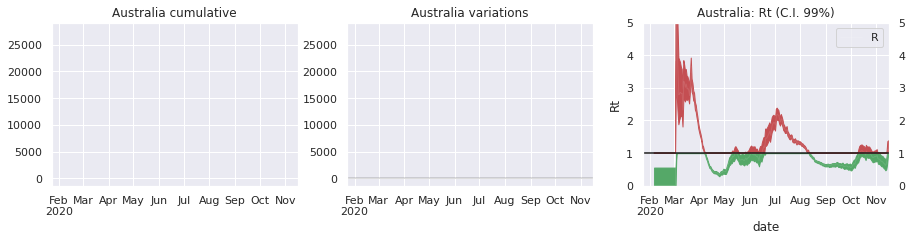

***

## Austria

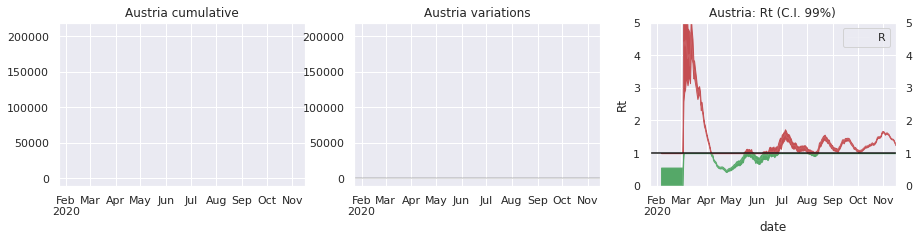

***

## Azerbaijan

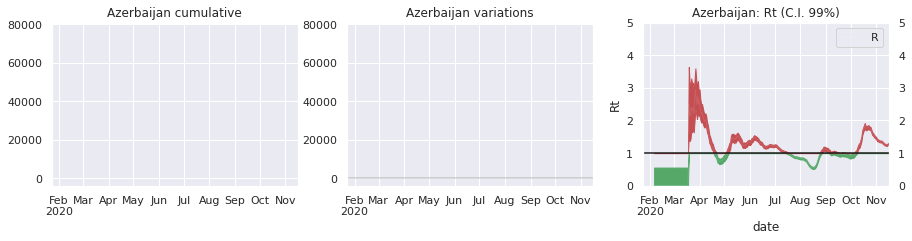

***

## Bahamas

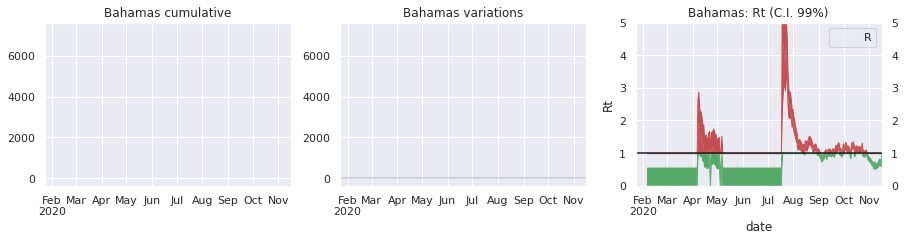

***

## Bahrain

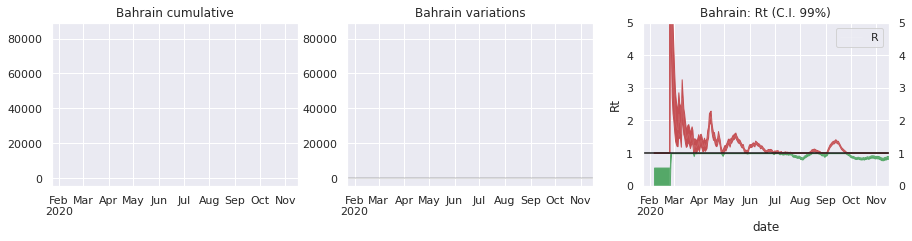

***

## Bangladesh

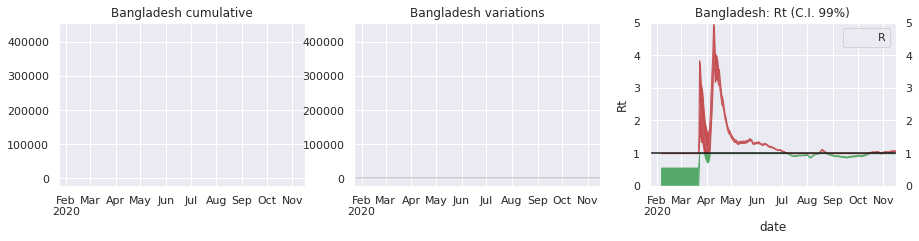

***

## Barbados

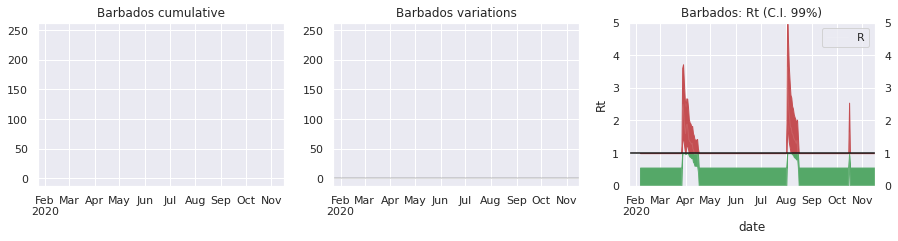

***

## Belarus

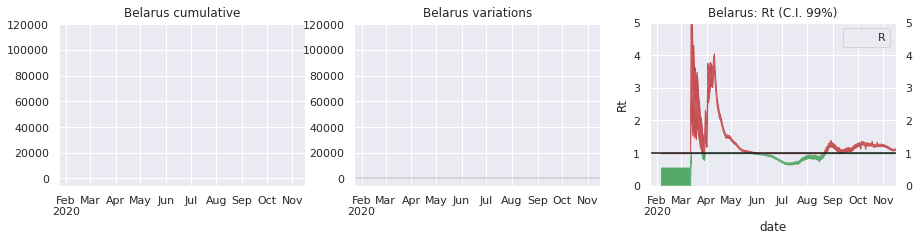

***

## Belgium

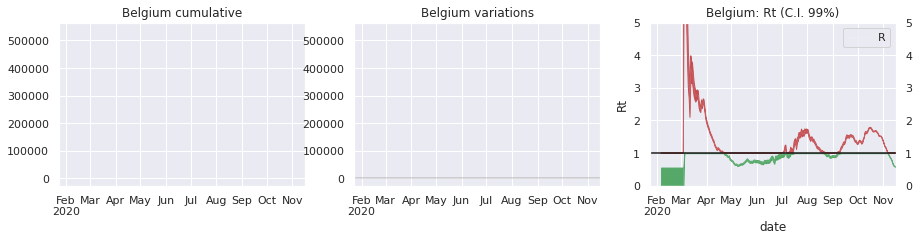

***

## Belize

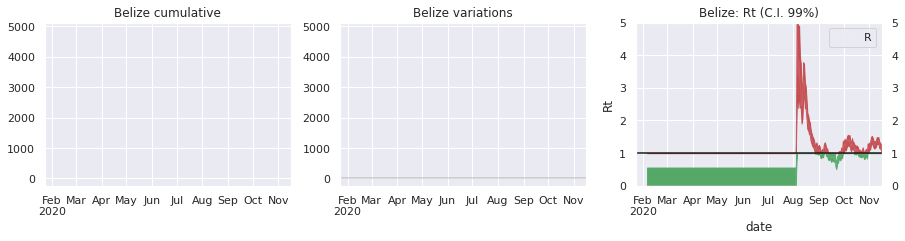

***

## Benin

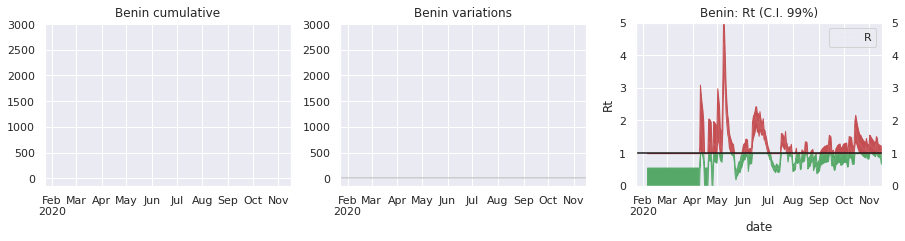

***

## Bhutan

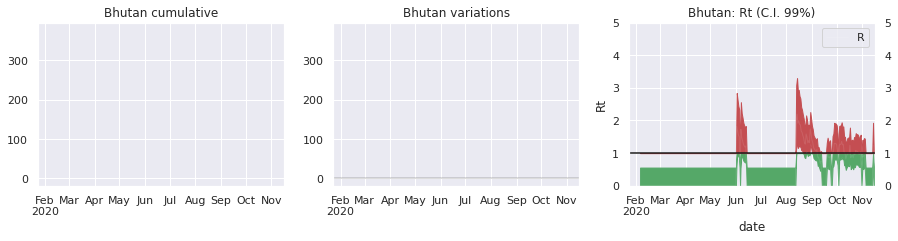

***

## Bolivia

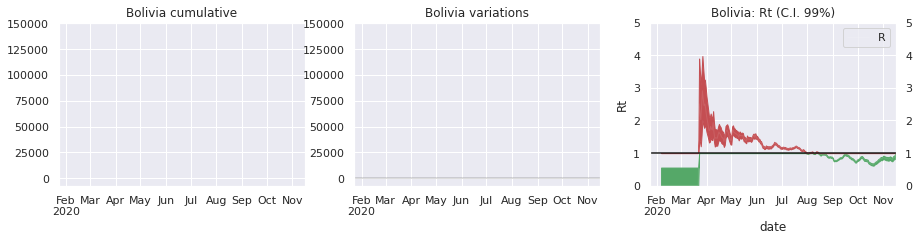

***

## Bosnia and Herzegovina

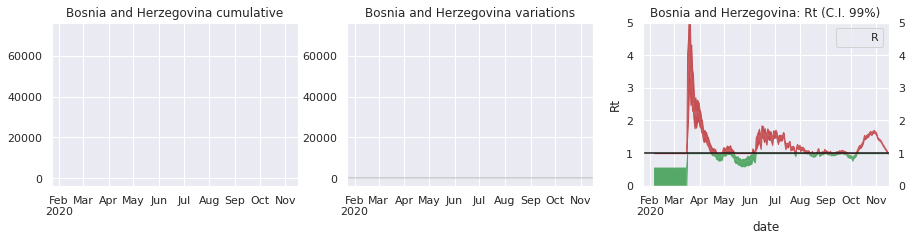

***

## Botswana

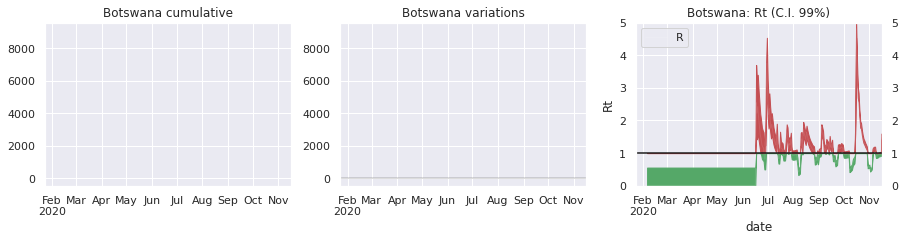

***

## Brazil

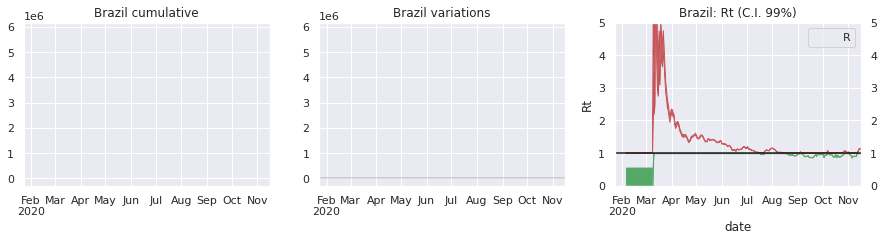

***

## Brunei

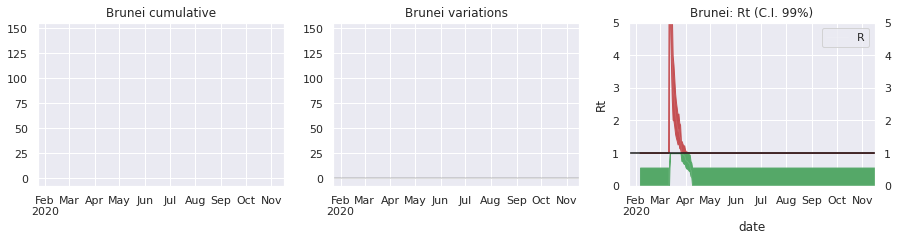

***

## Bulgaria

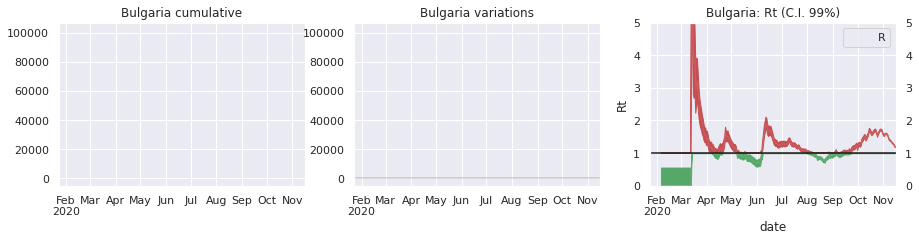

***

## Burkina Faso

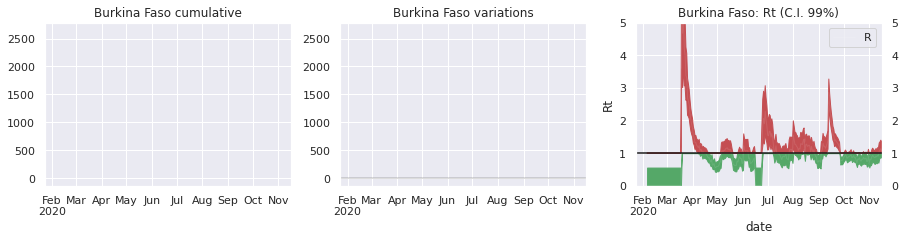

***

## Burma

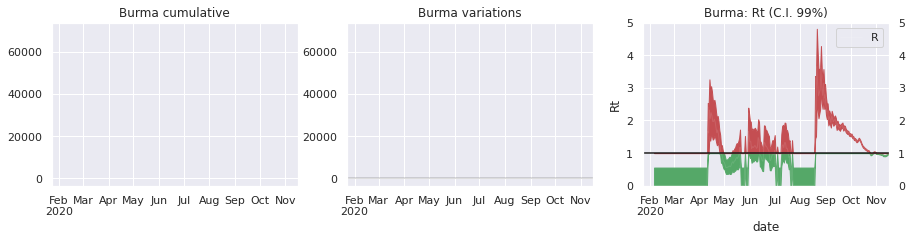

***

## Burundi

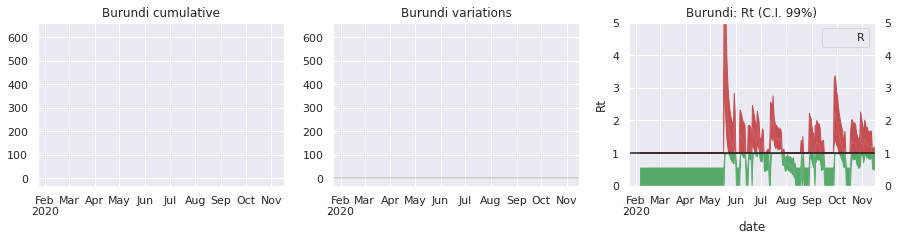

***

## Cabo Verde

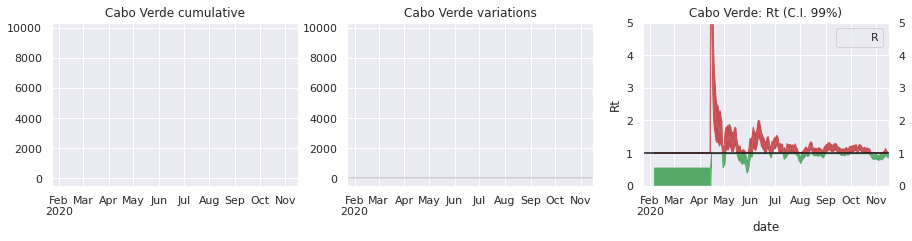

***

## Cambodia

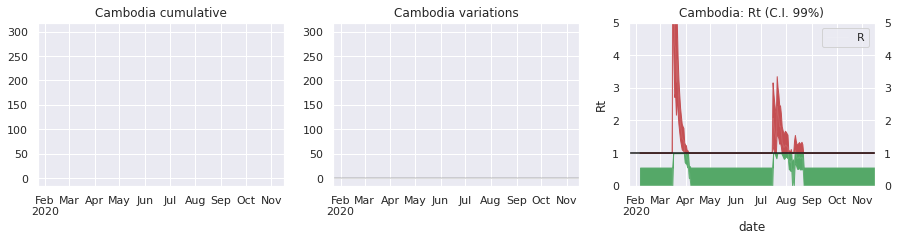

***

## Cameroon

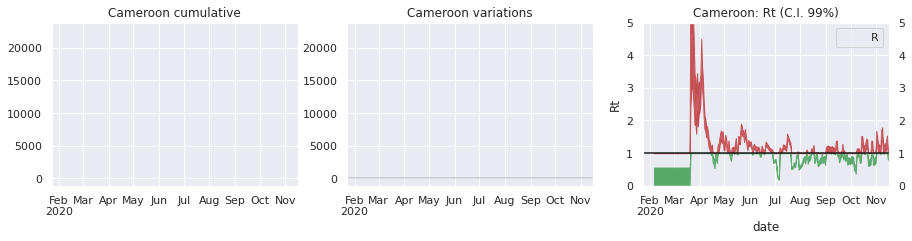

***

## Canada

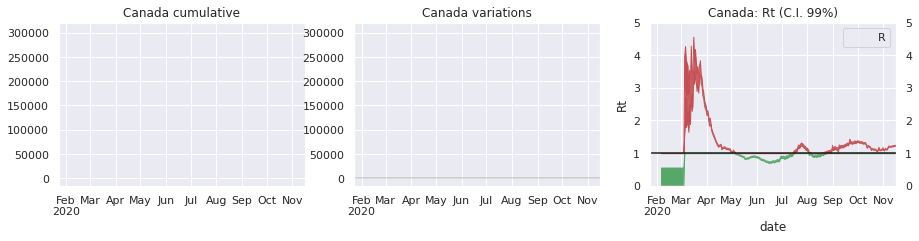

***

## Central African Republic

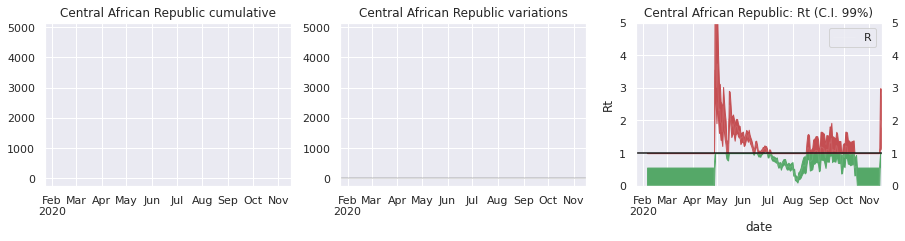

***

## Chad

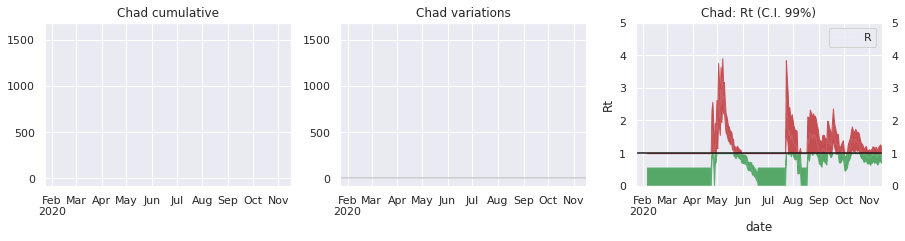

***

## Chile

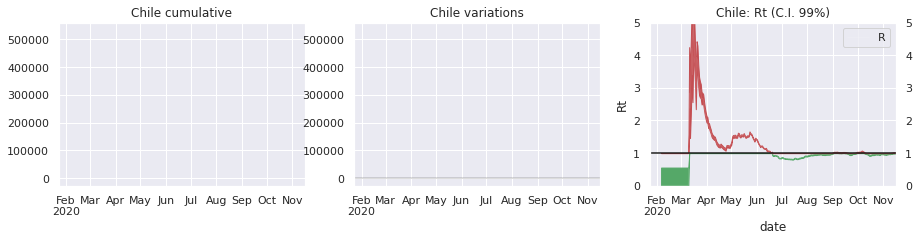

***

## China

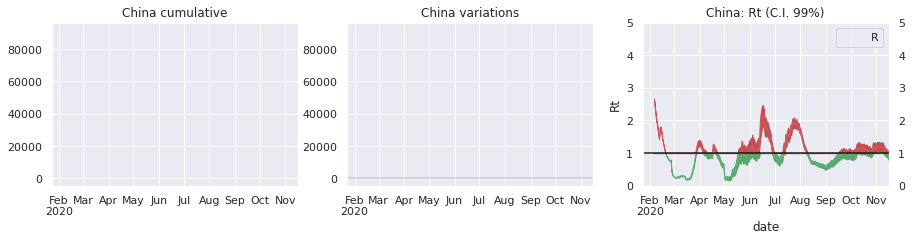

***

## Colombia

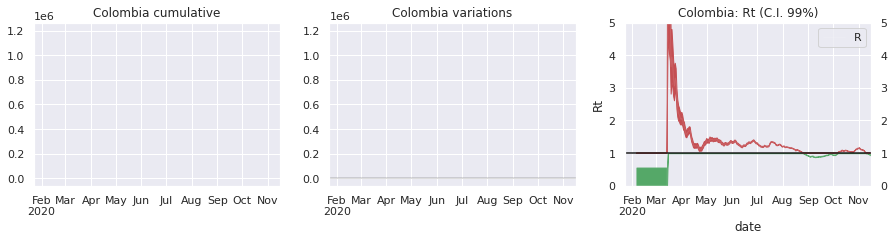

***

## Comoros

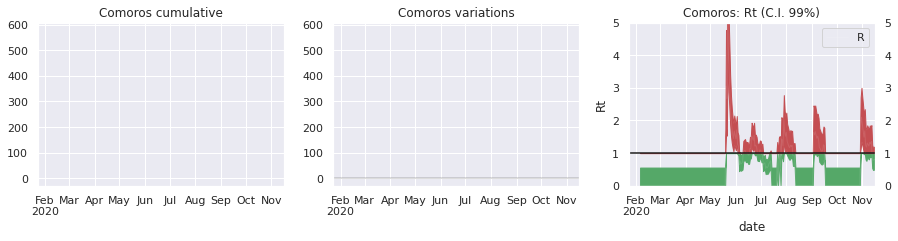

***

## Congo (Brazzaville)

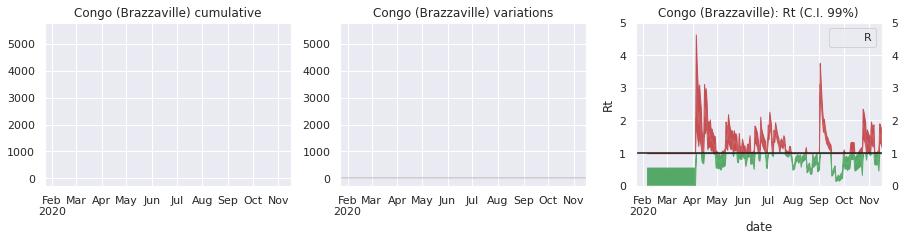

***

## Congo (Kinshasa)

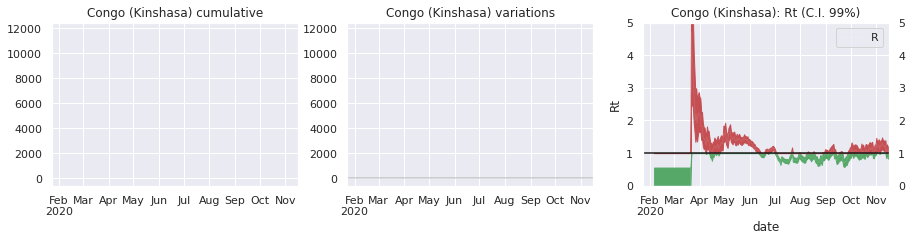

***

## Costa Rica

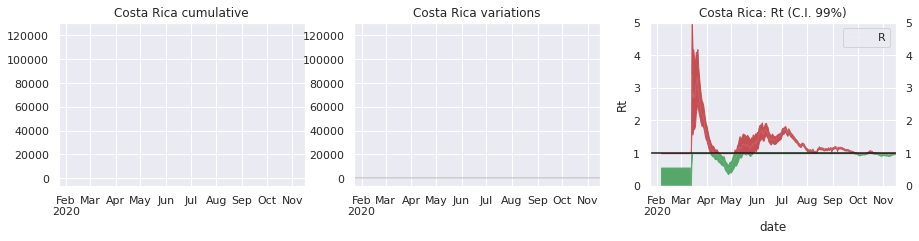

***

## Cote d'Ivoire

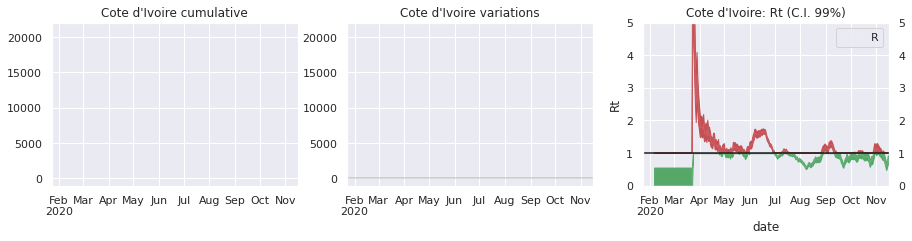

***

## Croatia

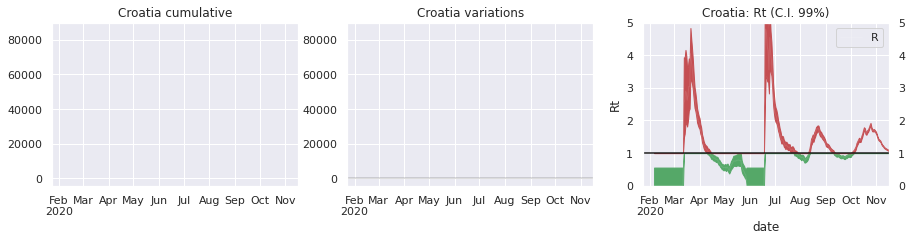

***

## Cuba

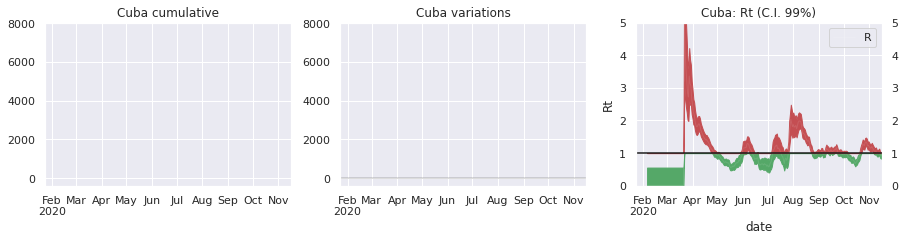

***

## Cyprus

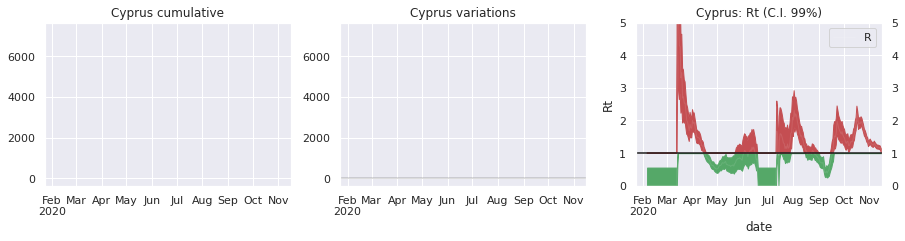

***

## Czechia

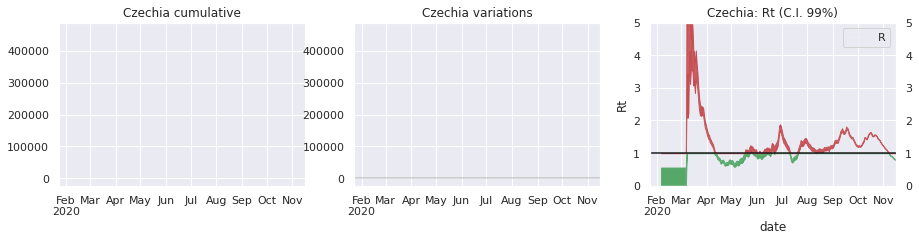

***

## Denmark

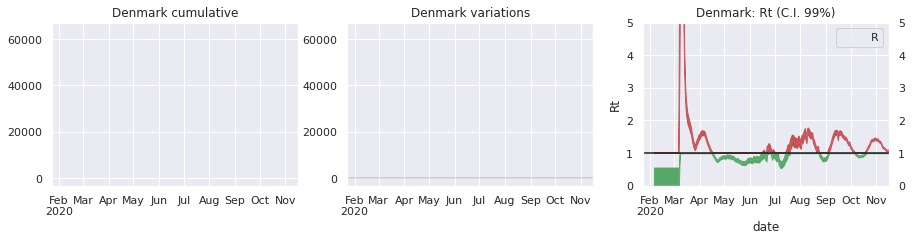

***

## Diamond Princess

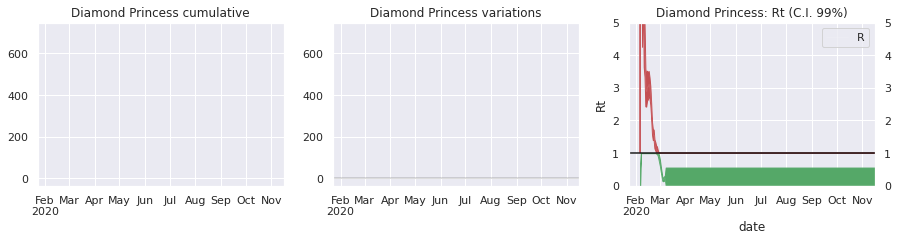

***

## Djibouti

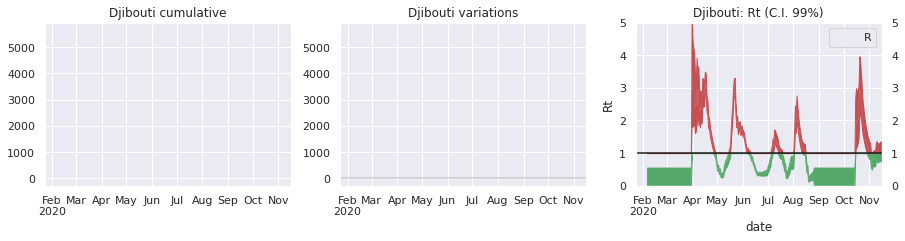

***

## Dominica

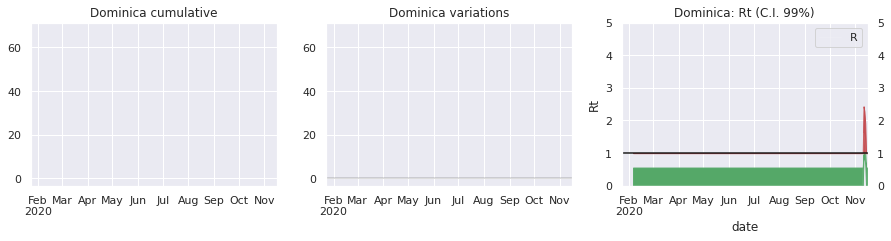

***

## Dominican Republic

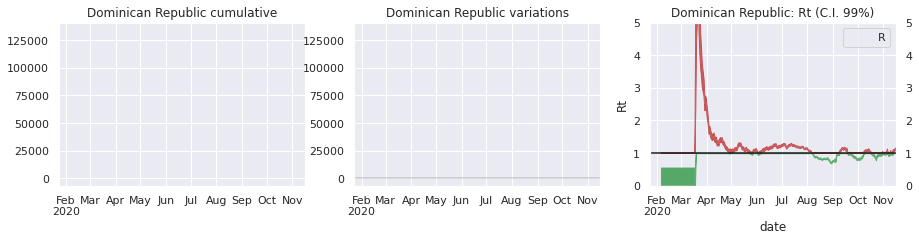

***

## Ecuador

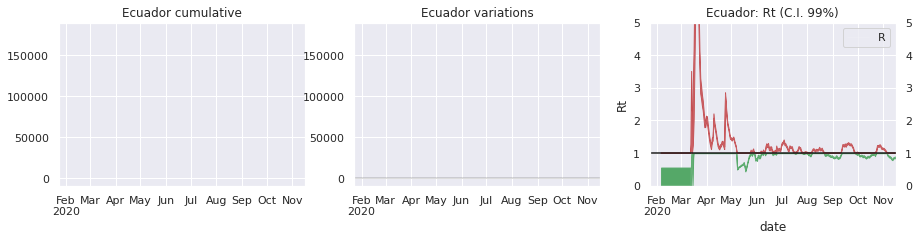

***

## Egypt

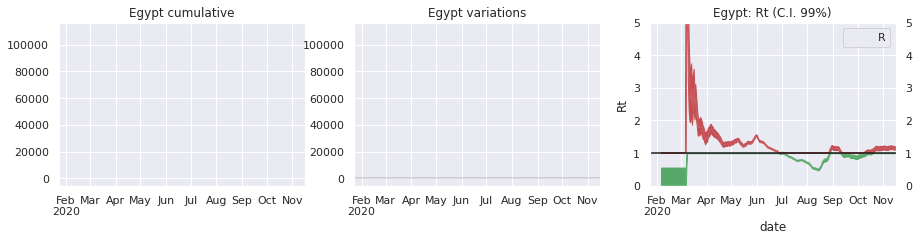

***

## El Salvador

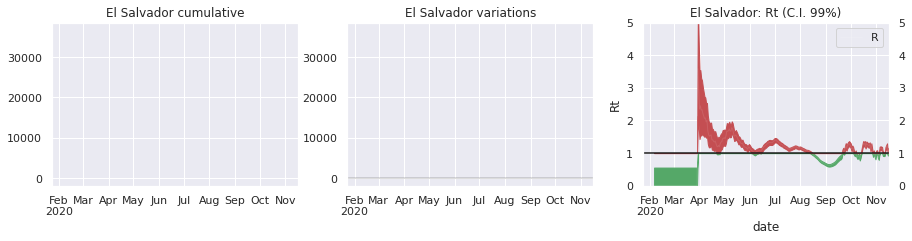

***

## Equatorial Guinea

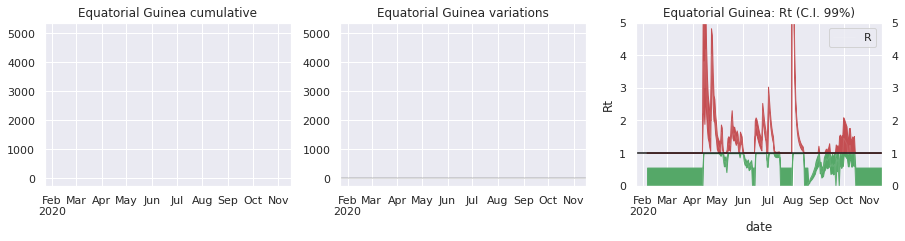

***

## Eritrea

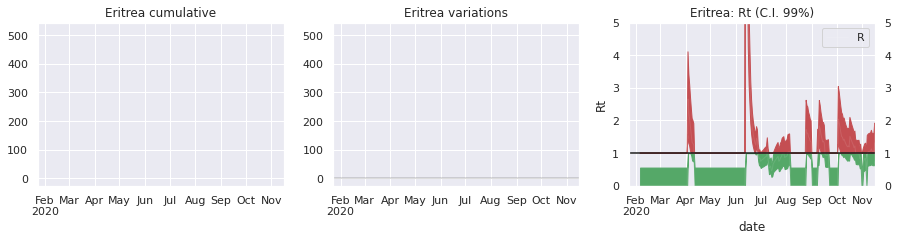

***

## Estonia

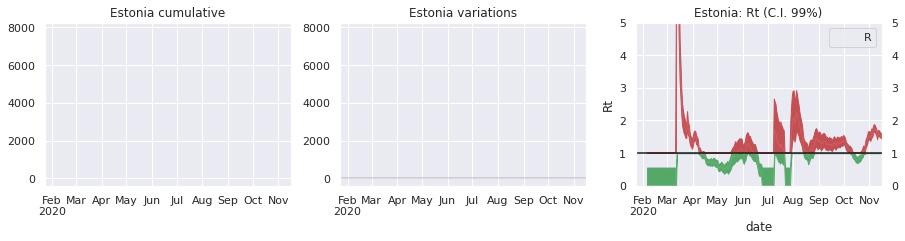

***

## Eswatini

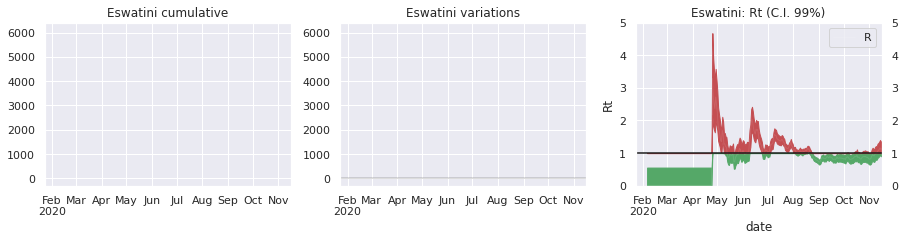

***

## Ethiopia

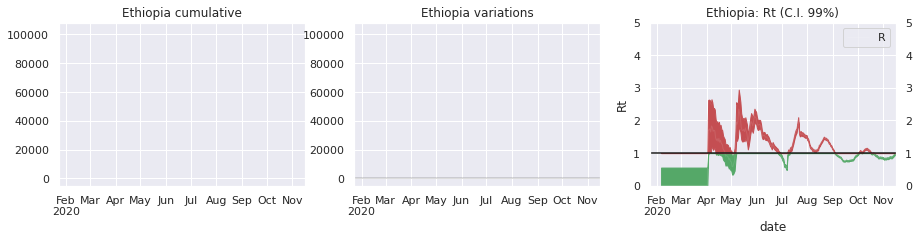

***

## Fiji

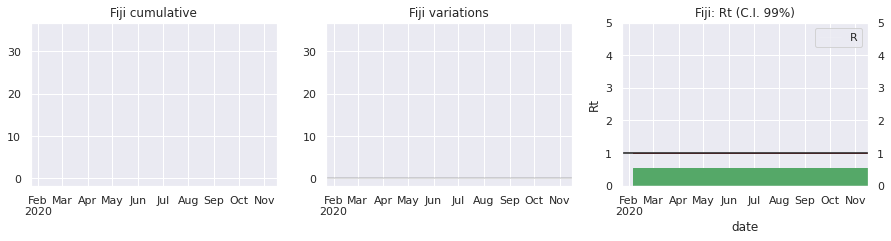

***

## Finland

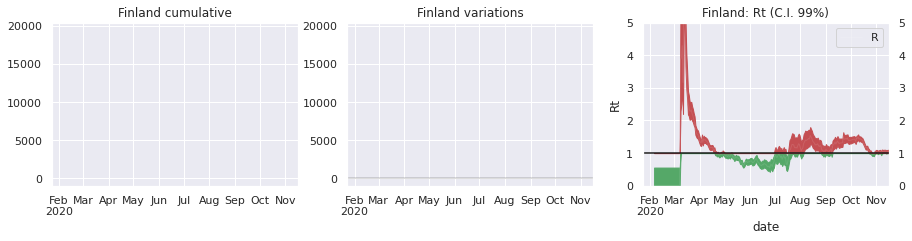

***

## France

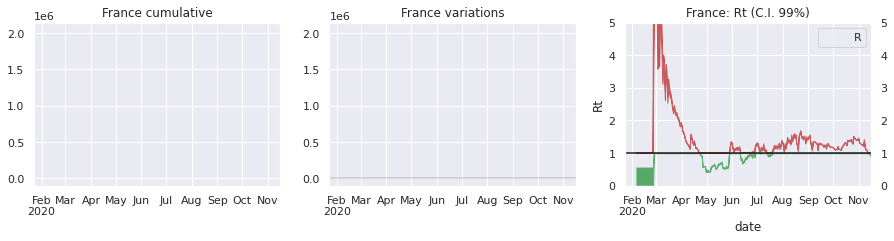

***

## Gabon

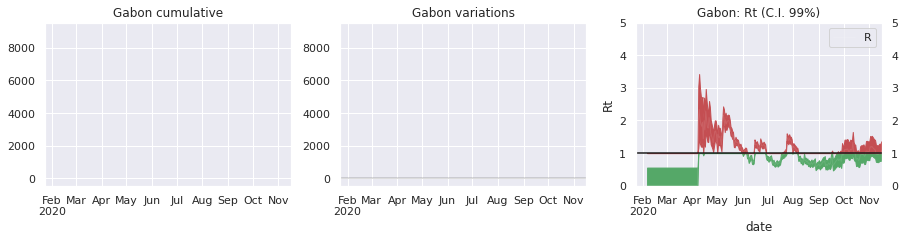

***

## Gambia

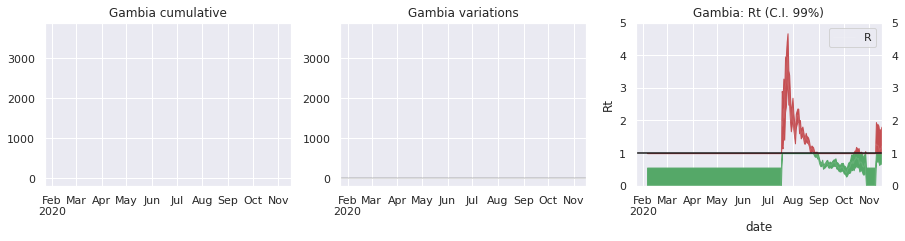

***

## Georgia

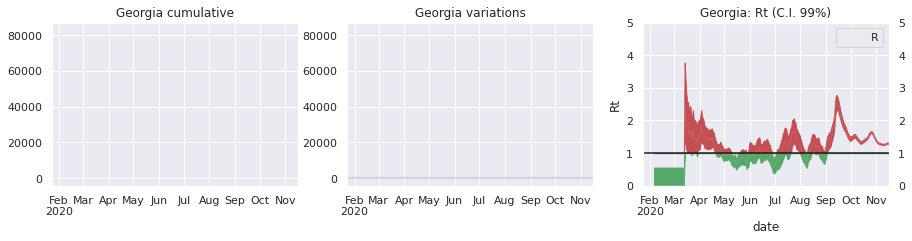

***

## Germany

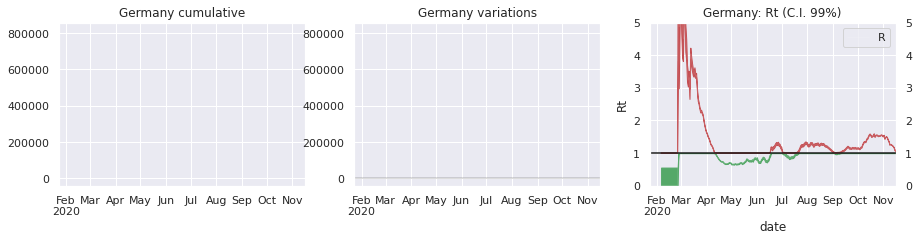

***

## Ghana

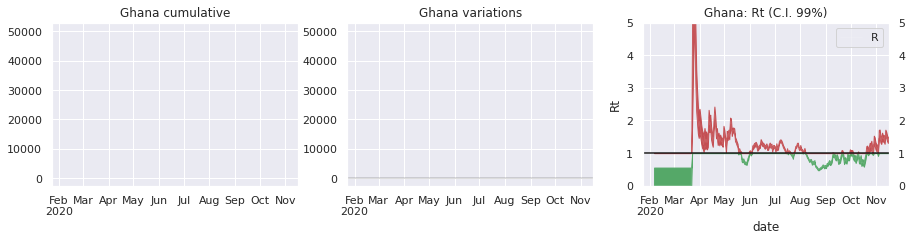

***

## Greece

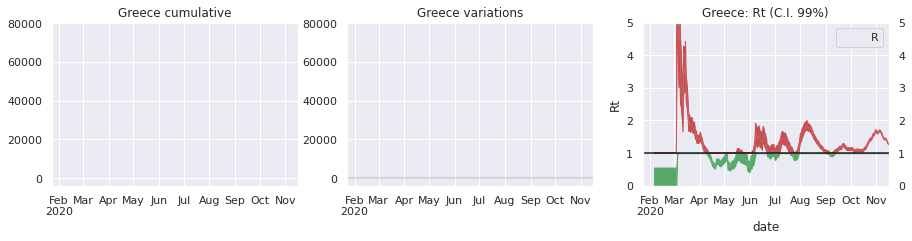

***

## Grenada

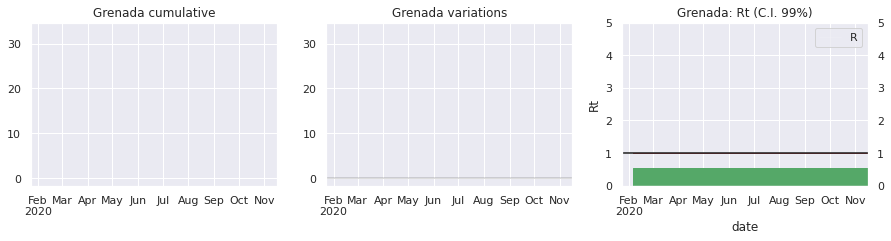

***

## Guatemala

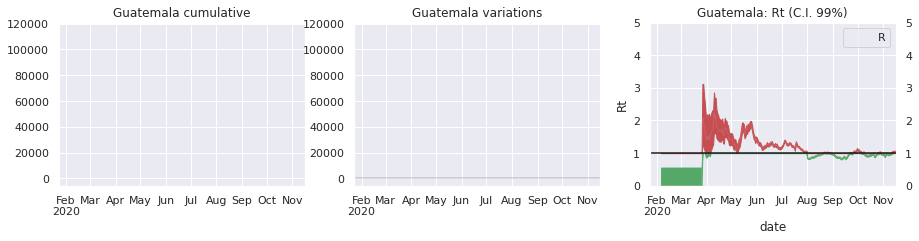

***

## Guinea

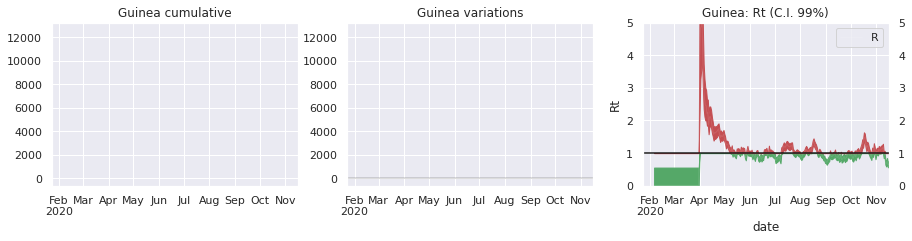

***

## Guinea-Bissau

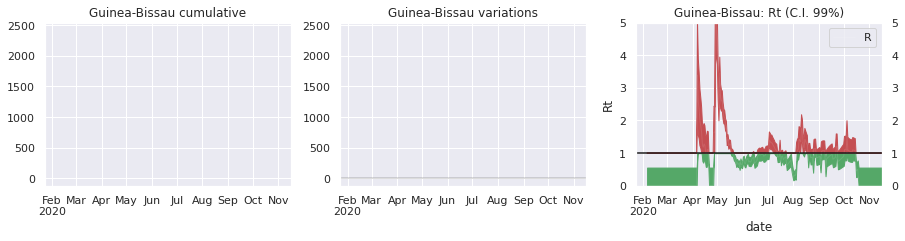

***

## Guyana

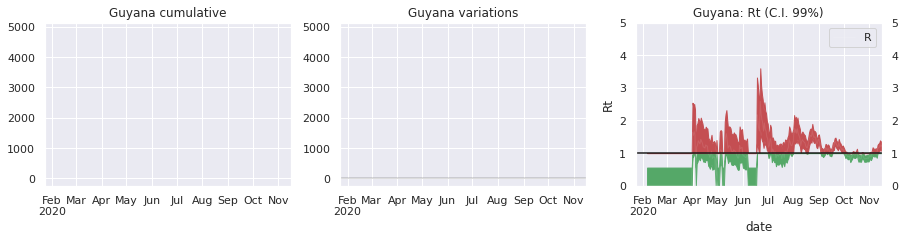

***

## Haiti

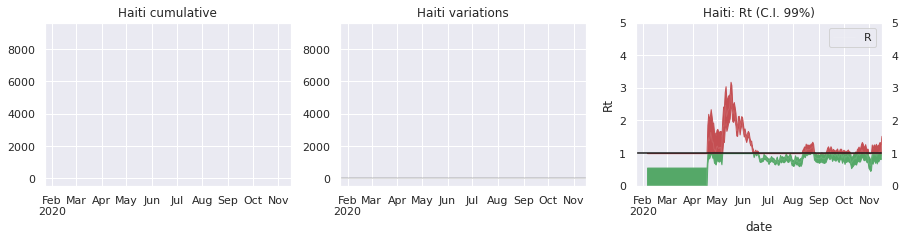

***

## Holy See

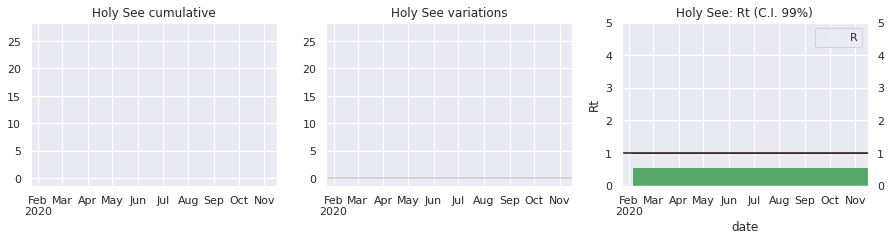

***

## Honduras

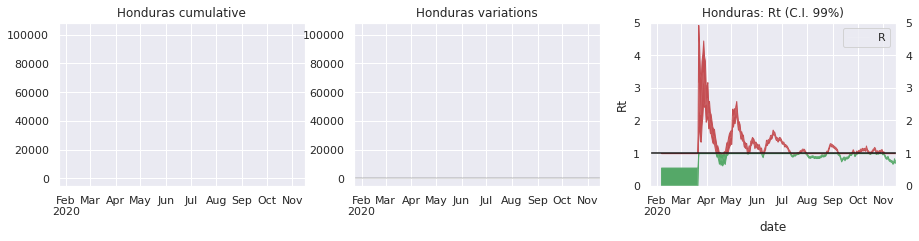

***

## Hungary

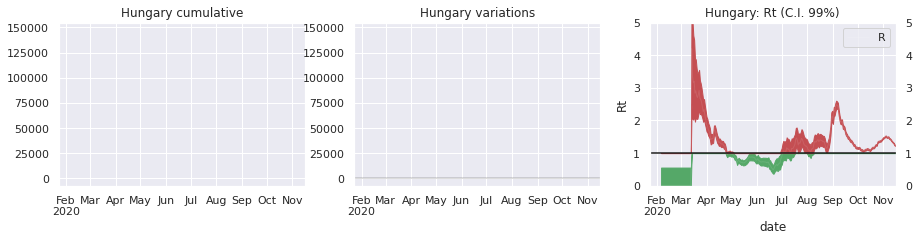

***

## Iceland

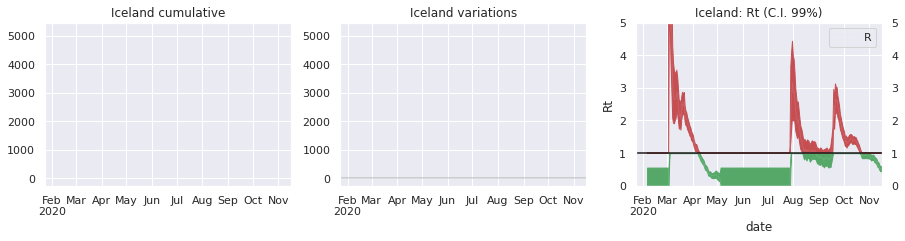

***

## India

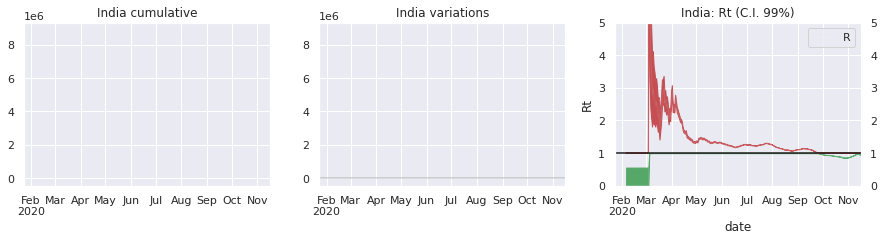

***

## Indonesia

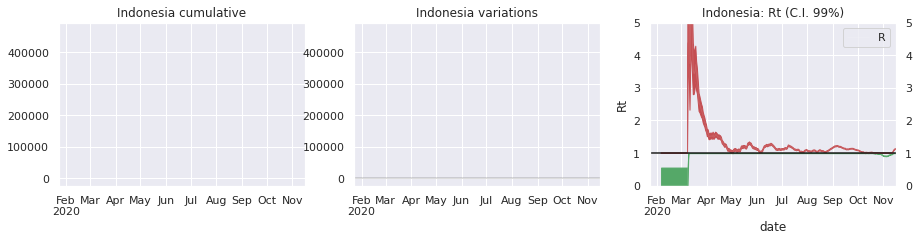

***

## Iran

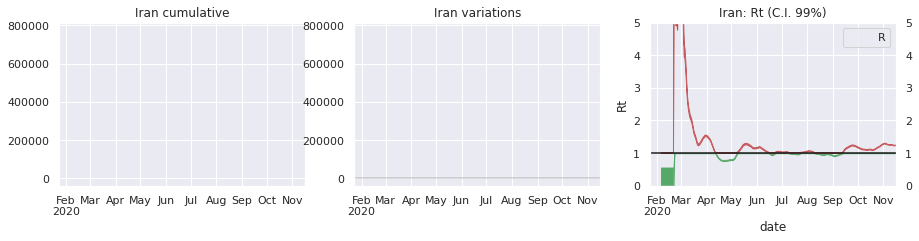

***

## Iraq

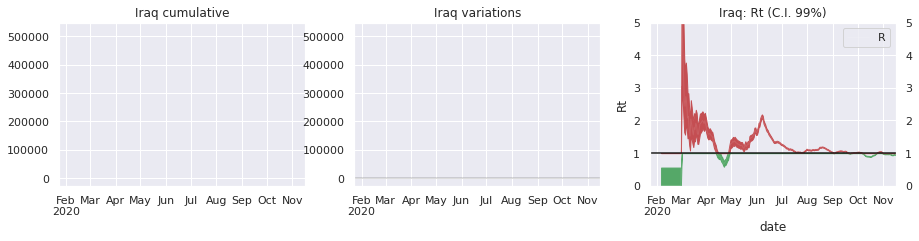

***

## Ireland

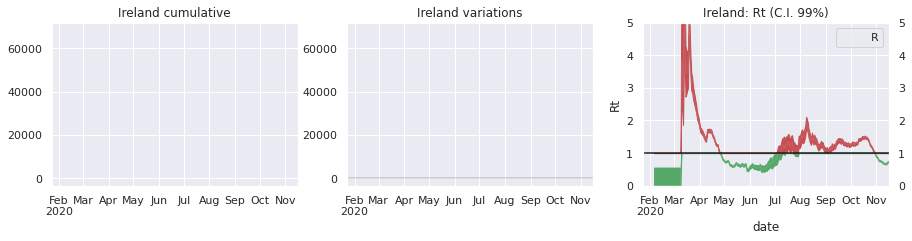

***

## Israel

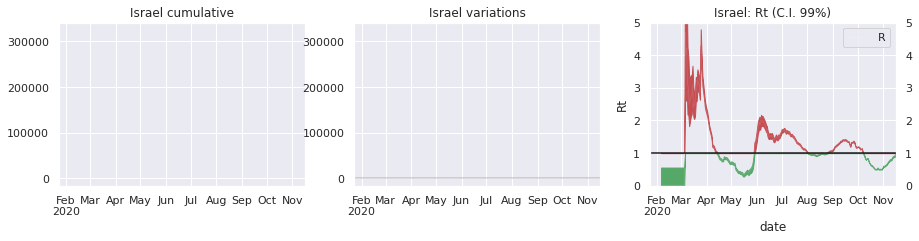

***

## Italy

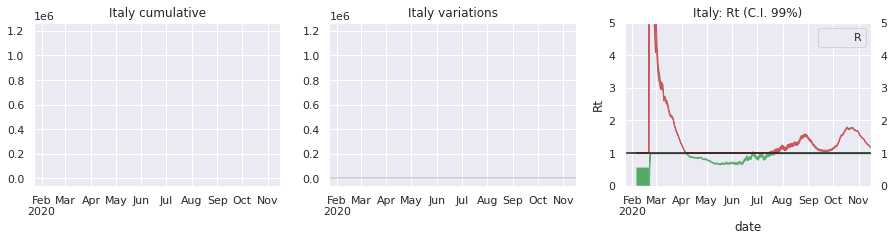

***

## Jamaica

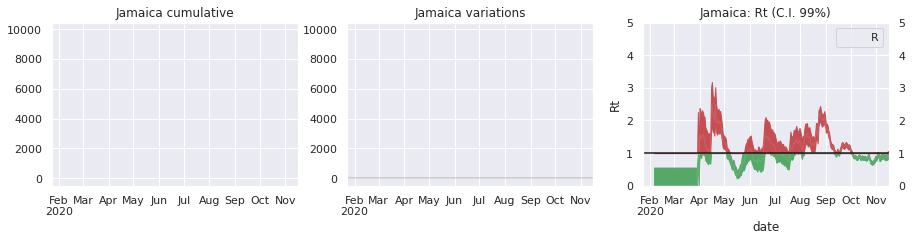

***

## Japan

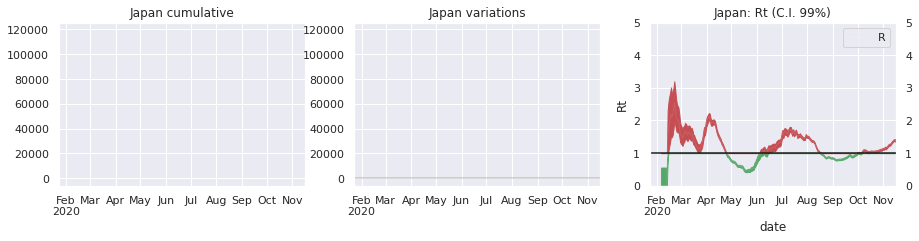

***

## Jordan

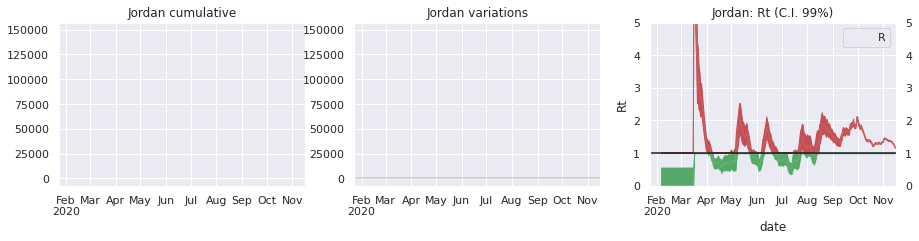

***

## Kazakhstan

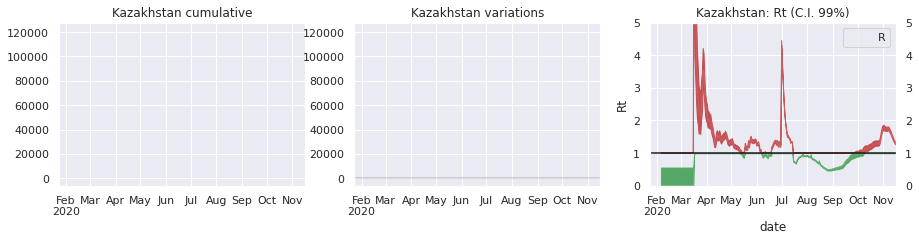

***

## Kenya

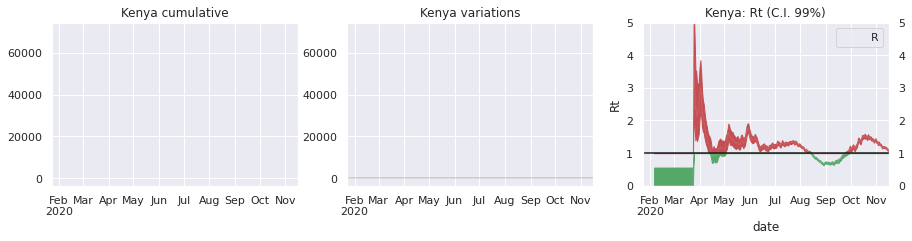

***

## Korea, South

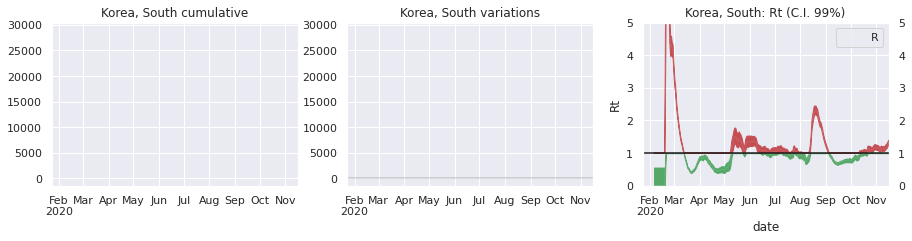

***

## Kosovo

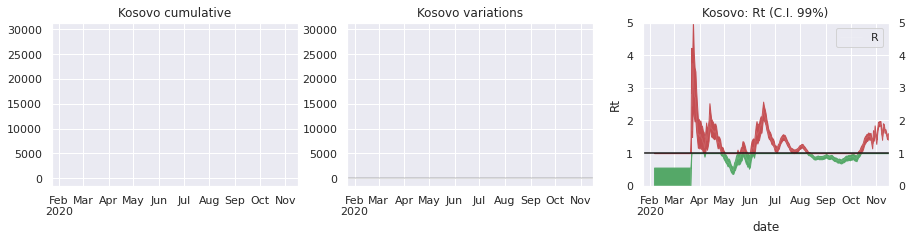

***

## Kuwait

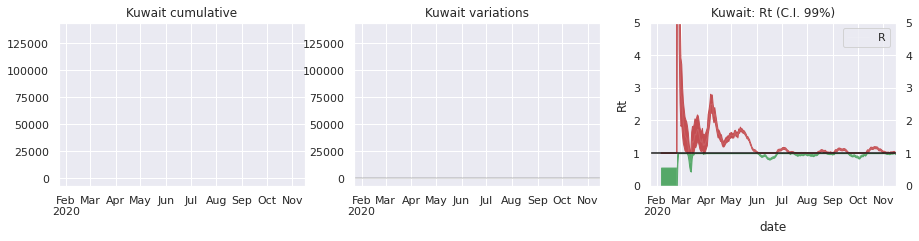

***

## Kyrgyzstan

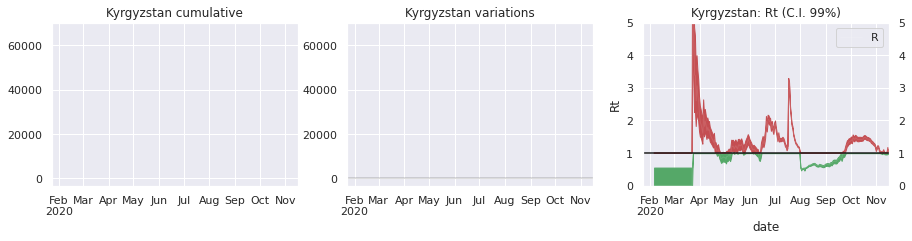

***

## Laos

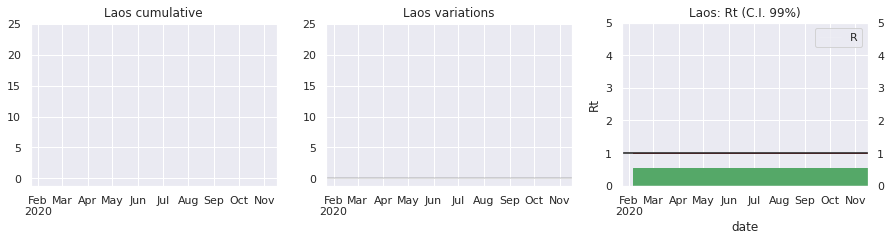

***

## Latvia

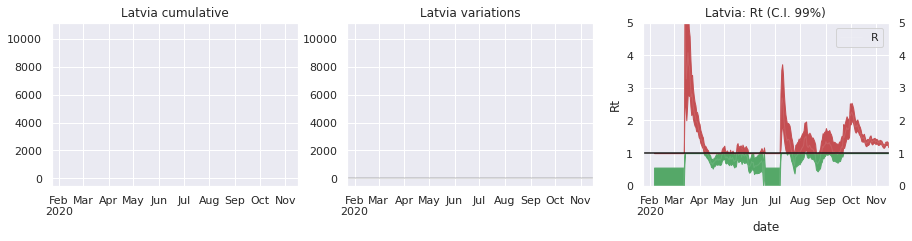

***

## Lebanon

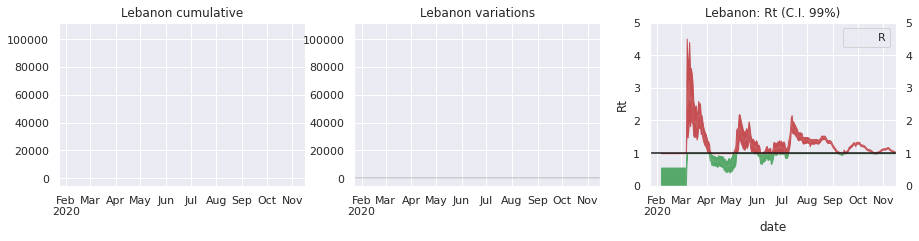

***

## Lesotho

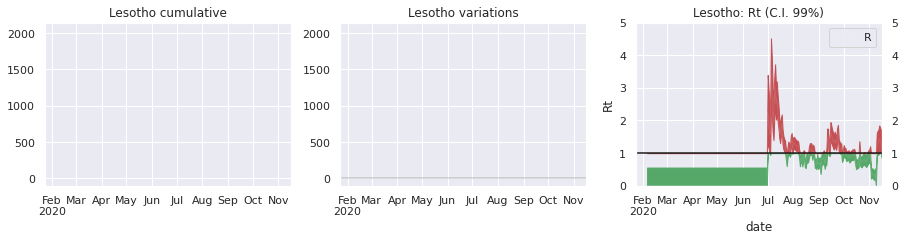

***

## Liberia

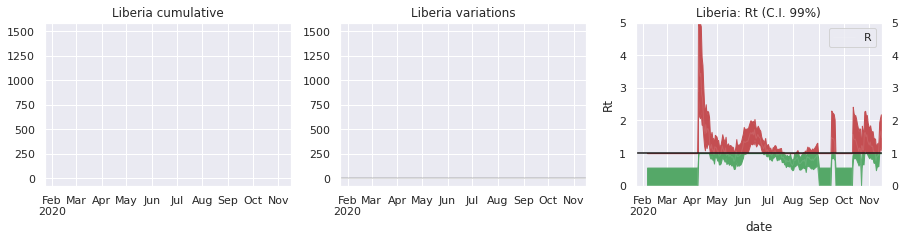

***

## Libya

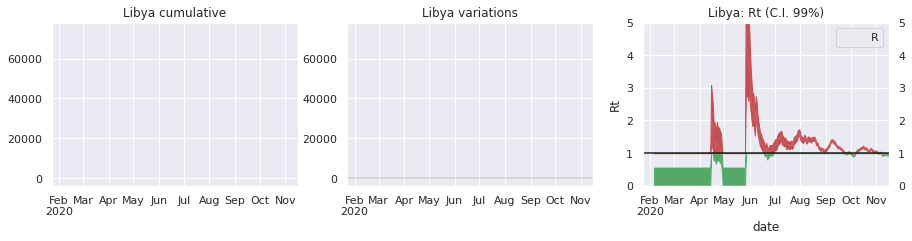

***

## Liechtenstein

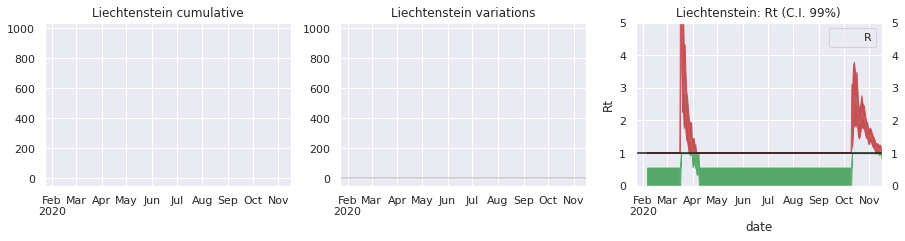

***

## Lithuania

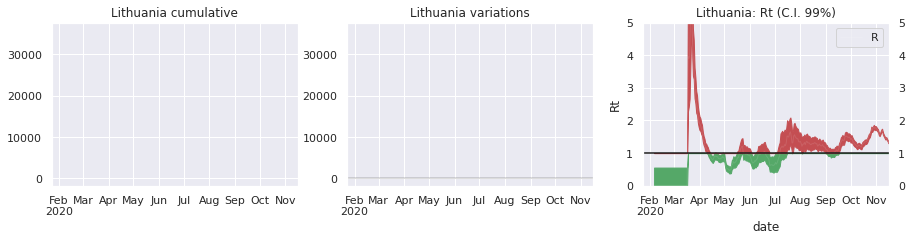

***

## Luxembourg

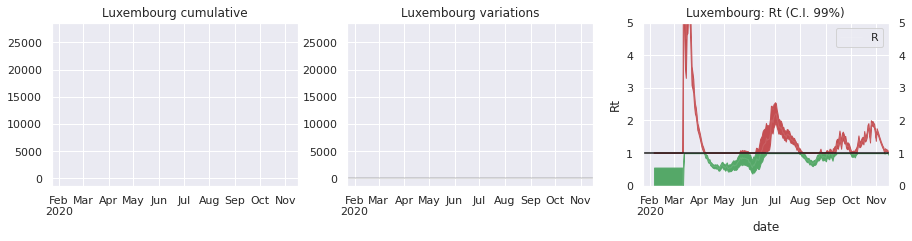

***

## MS Zaandam

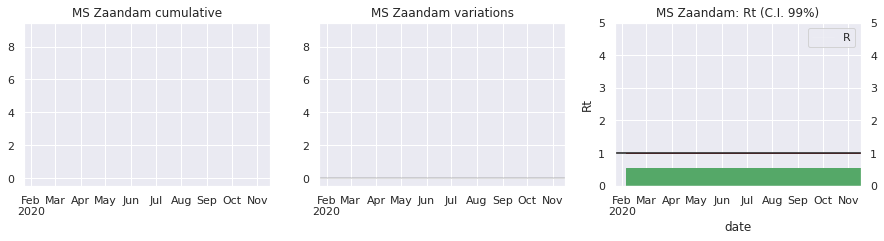

***

## Madagascar

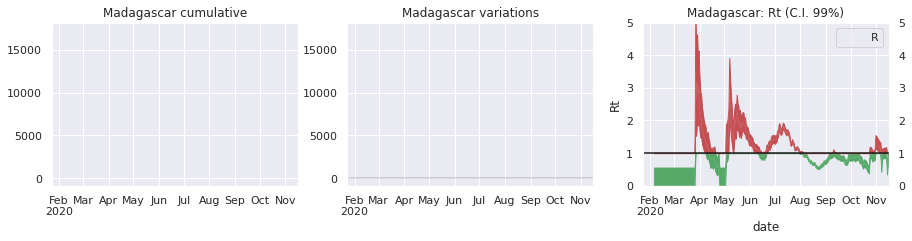

***

## Malawi

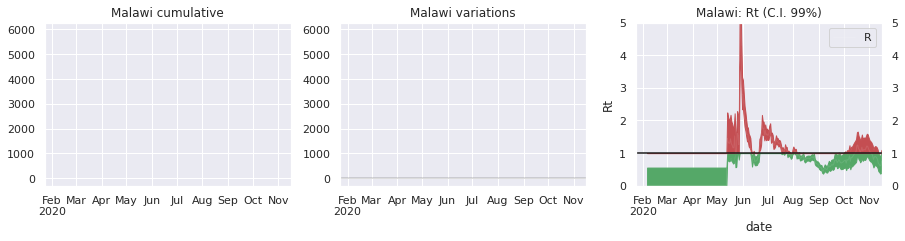

***

## Malaysia

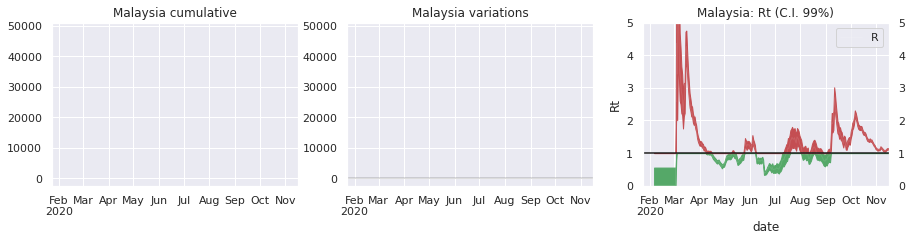

***

## Maldives

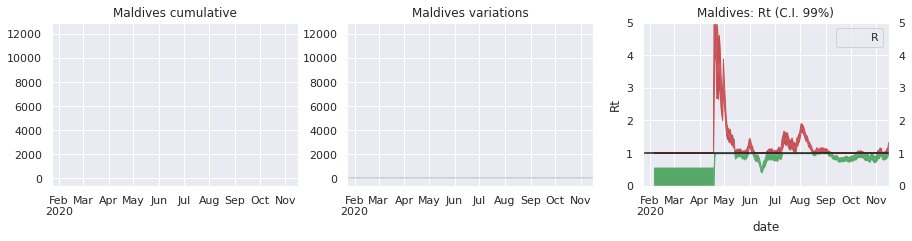

***

## Mali

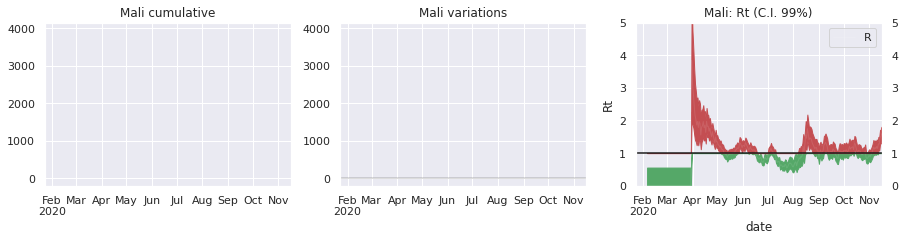

***

## Malta

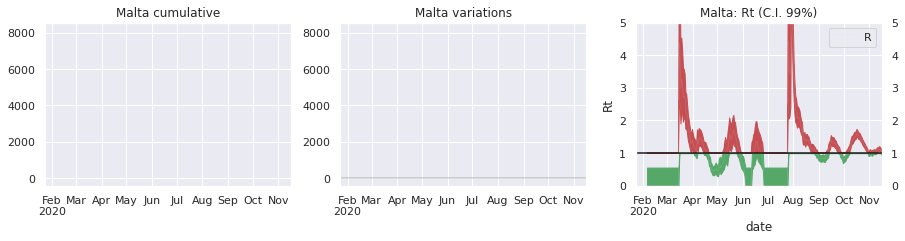

***

## Marshall Islands

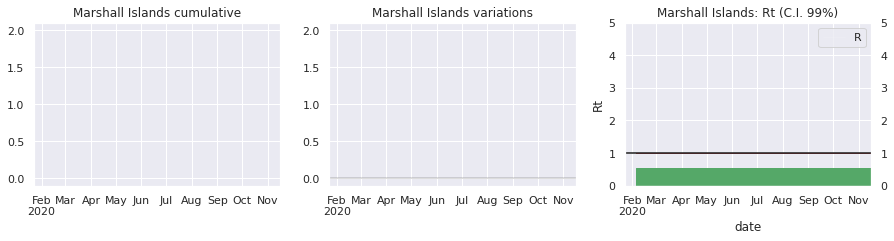

***

## Mauritania

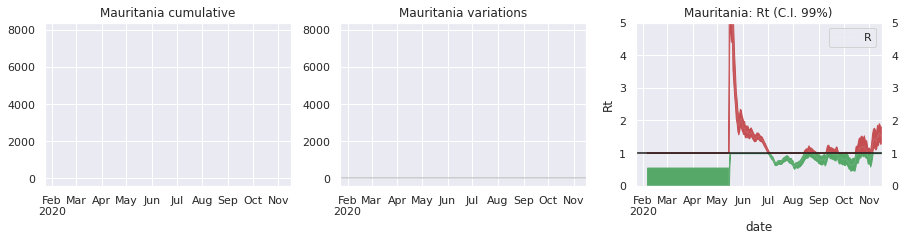

***

## Mauritius

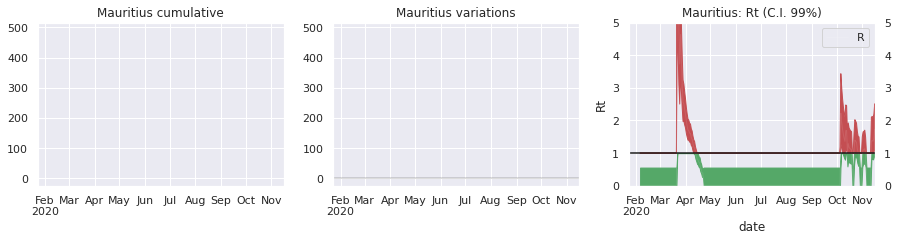

***

## Mexico

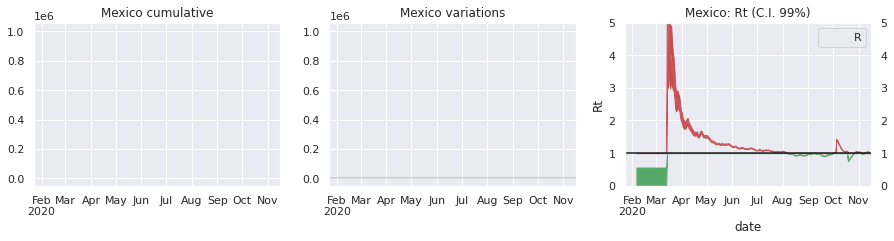

***

## Moldova

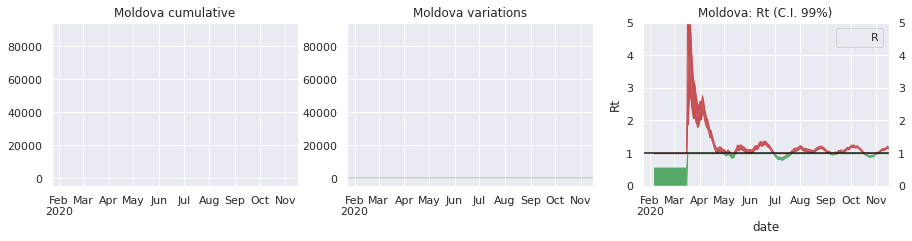

***

## Monaco

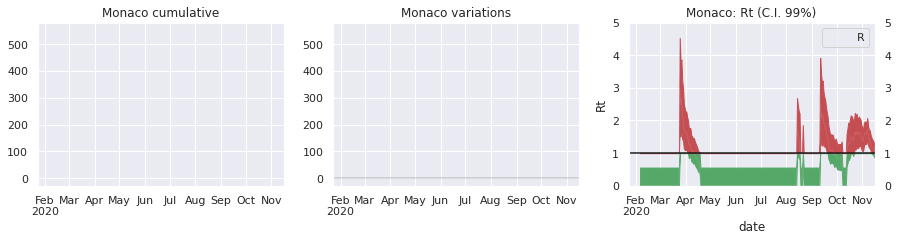

***

## Mongolia

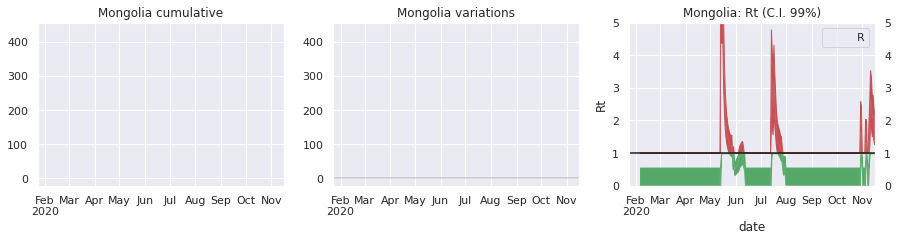

***

## Montenegro

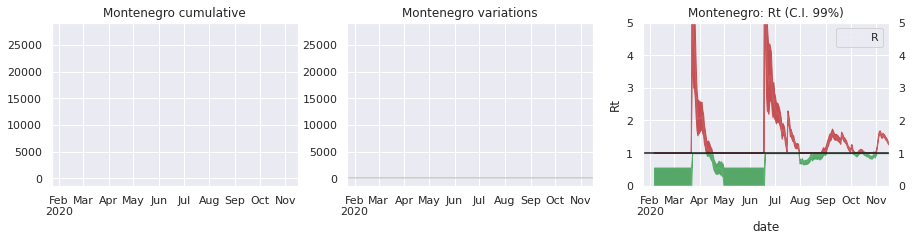

***

## Morocco

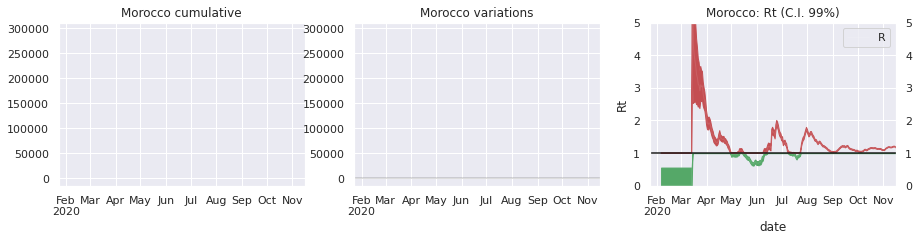

***

## Mozambique

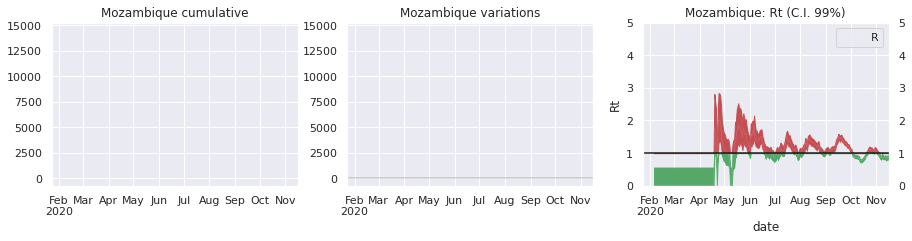

***

## Namibia

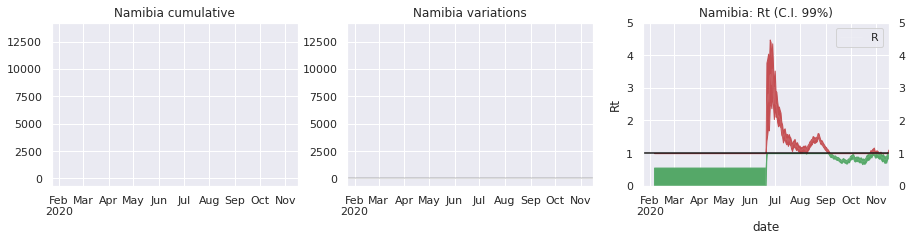

***

## Nepal

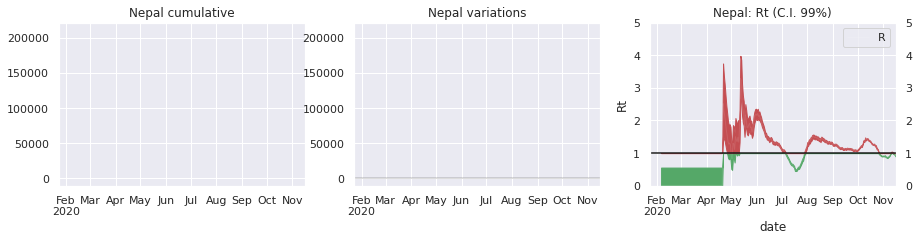

***

## Netherlands

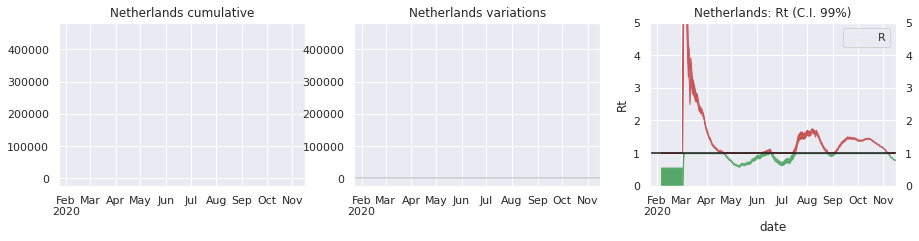

***

## New Zealand

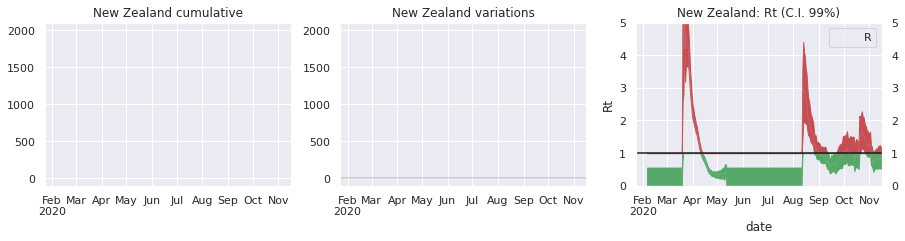

***

## Nicaragua

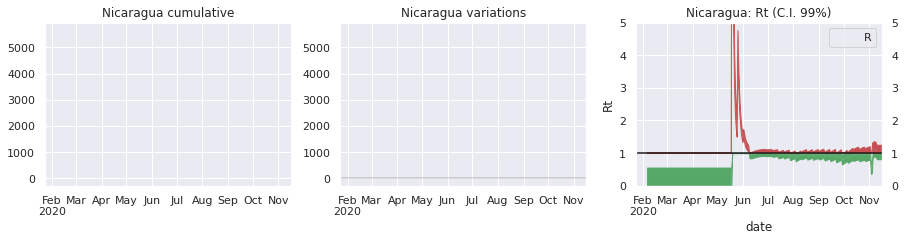

***

## Niger

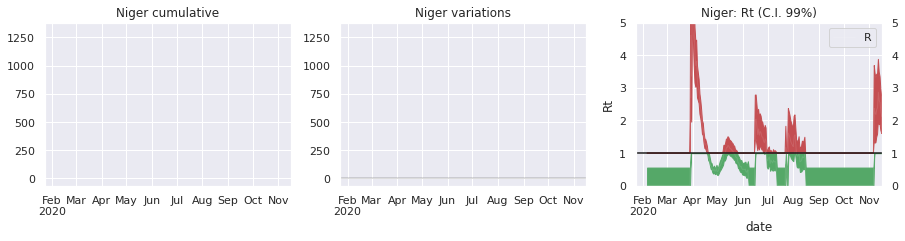

***

## Nigeria

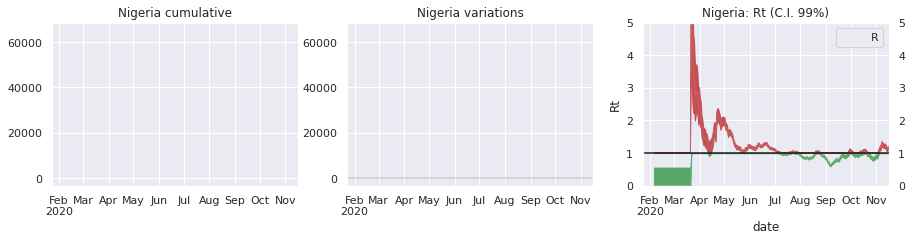

***

## North Macedonia

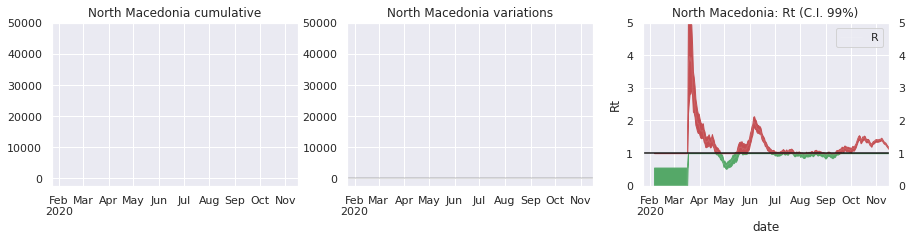

***

## Norway

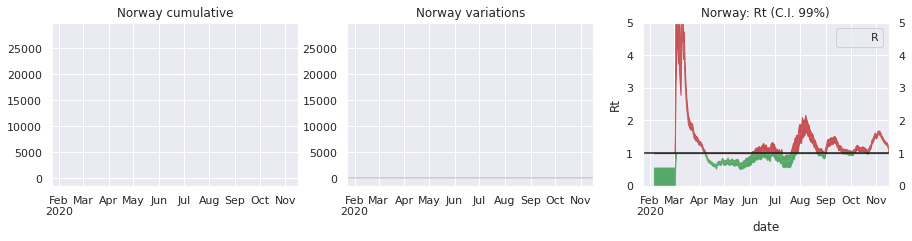

***

## Oman

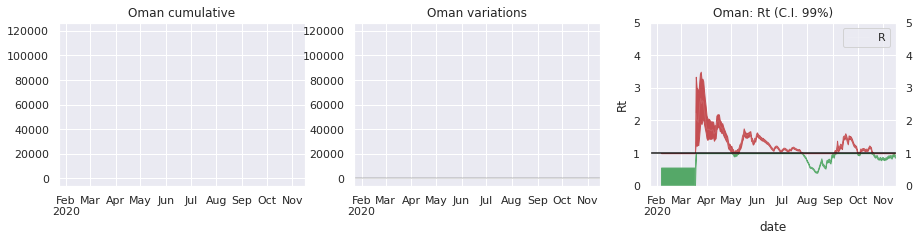

***

## Pakistan

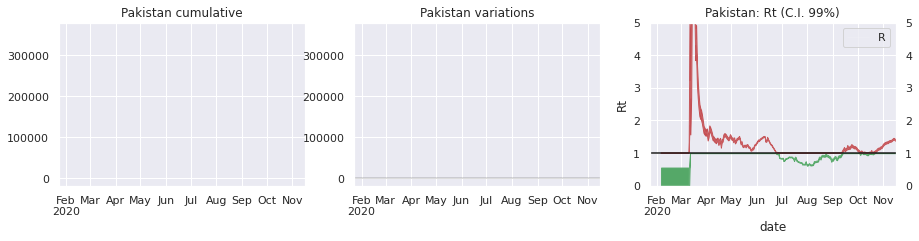

***

## Panama

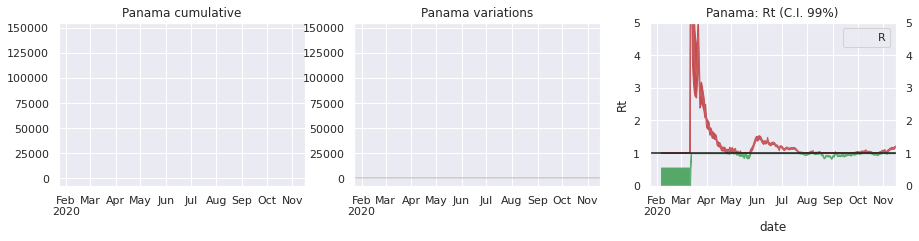

***

## Papua New Guinea

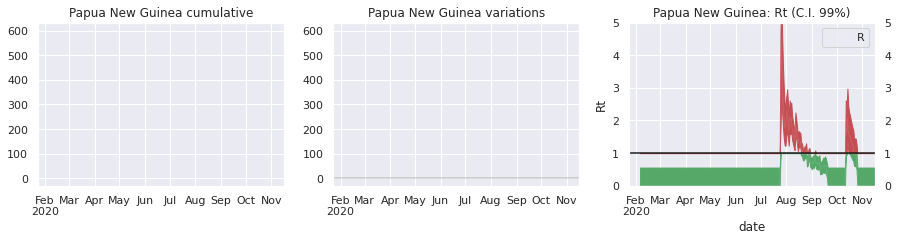

***

## Paraguay

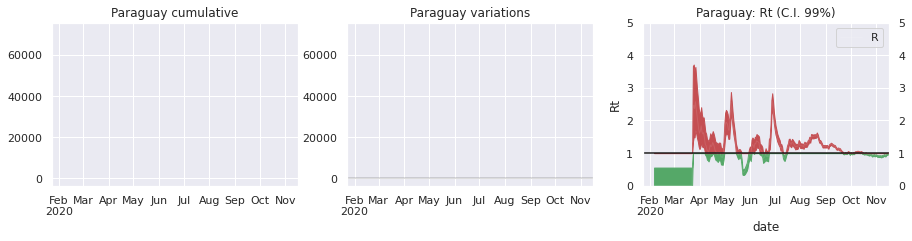

***

## Peru

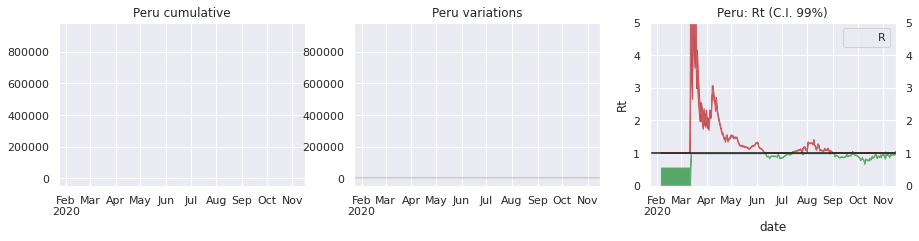

***

## Philippines

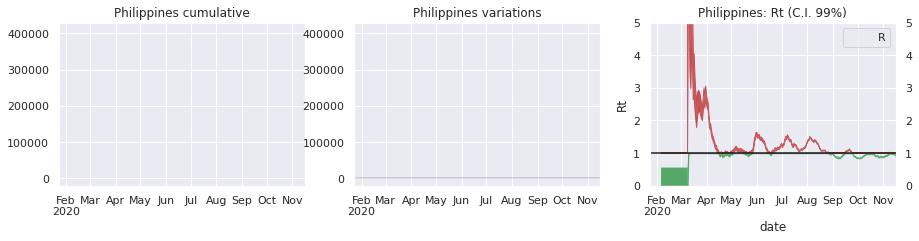

***

## Poland

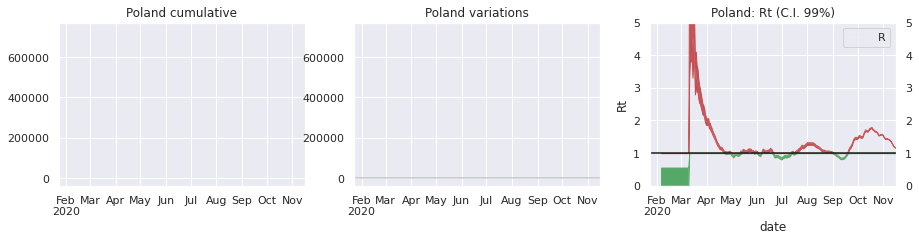

***

## Portugal

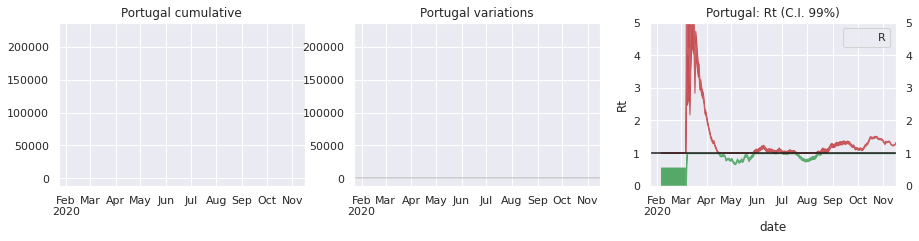

***

## Qatar

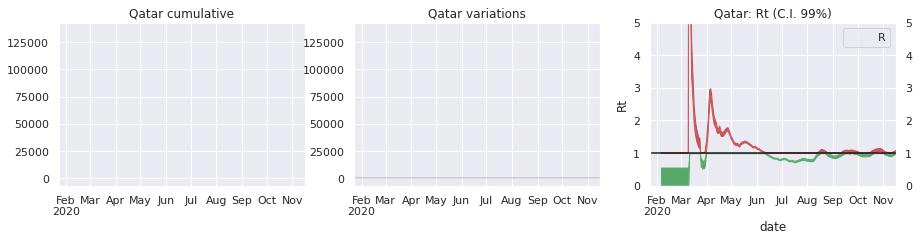

***

## Romania

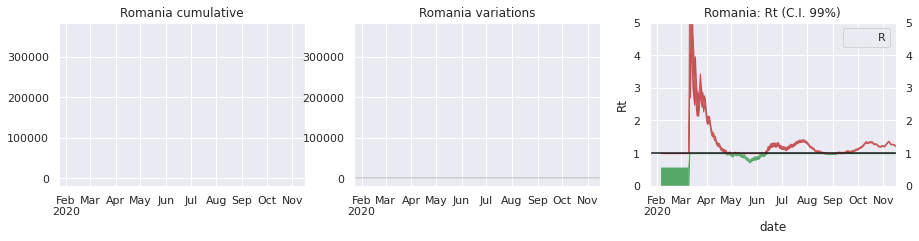

***

## Russia

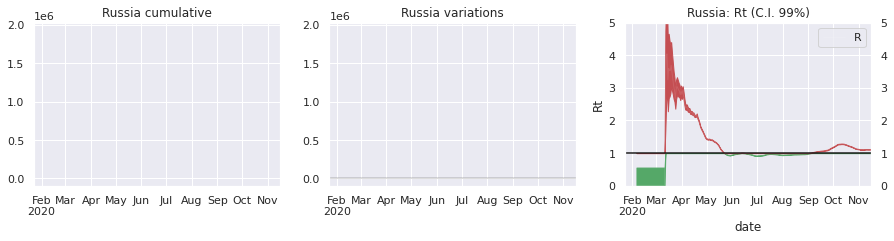

***

## Rwanda

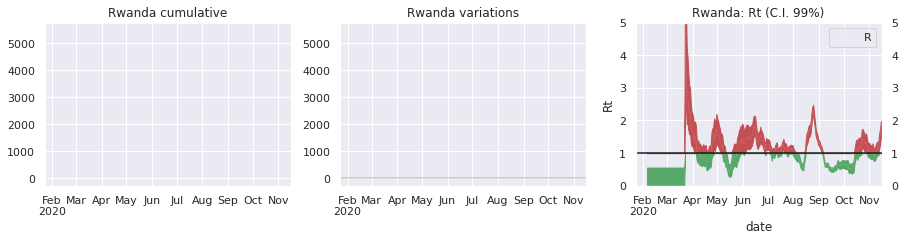

***

## Saint Kitts and Nevis

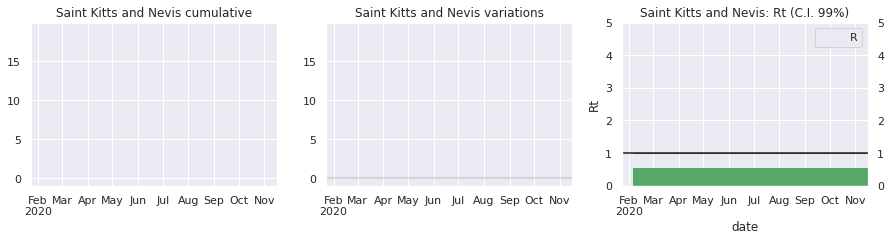

***

## Saint Lucia

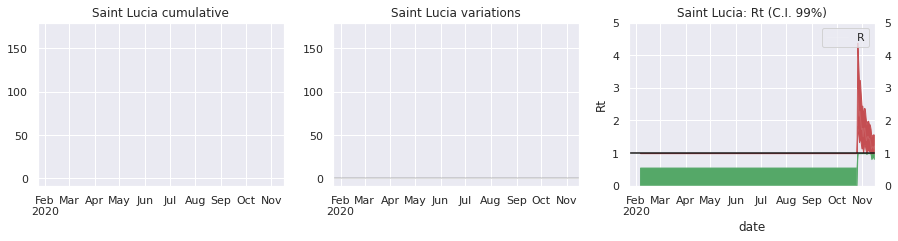

***

## Saint Vincent and the Grenadines

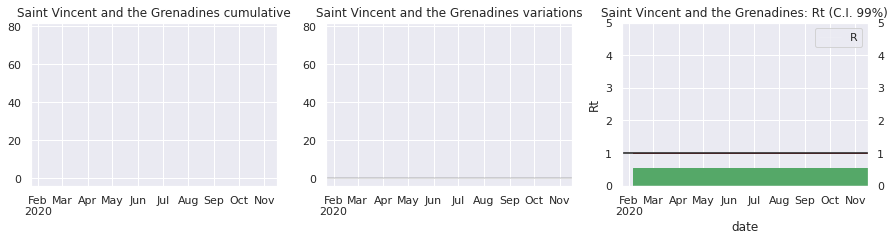

***

## San Marino

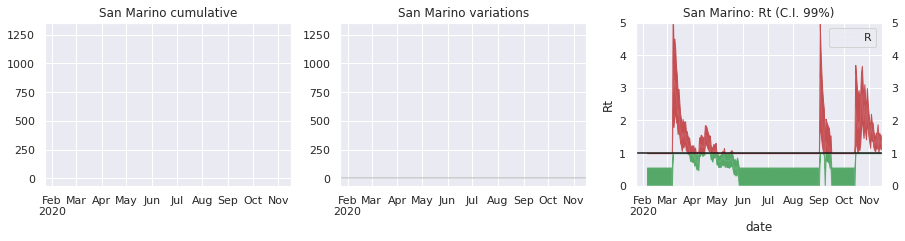

***

## Sao Tome and Principe

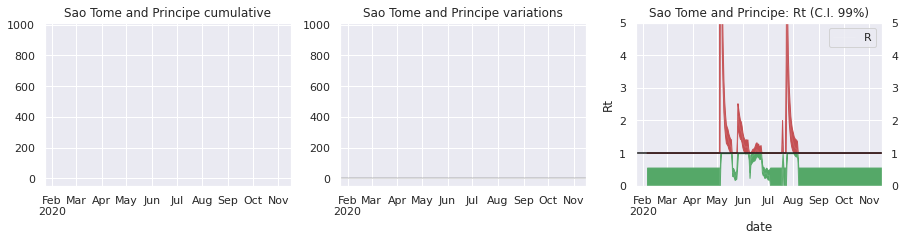

***

## Saudi Arabia

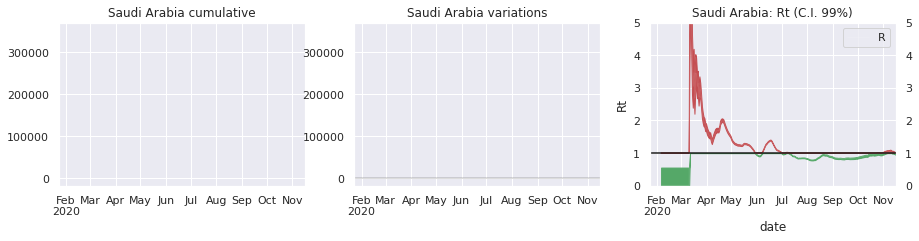

***

## Senegal

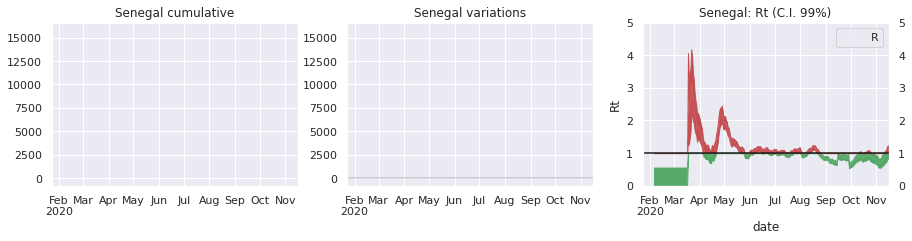

***

## Serbia

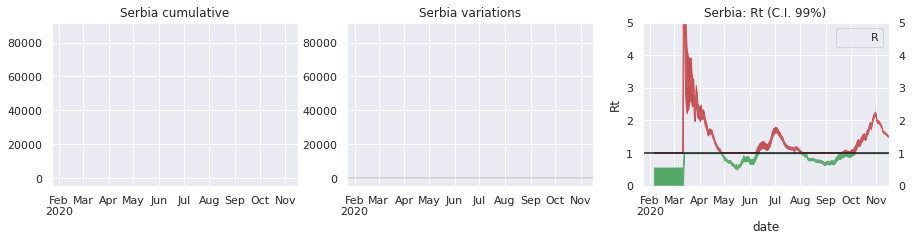

***

## Seychelles

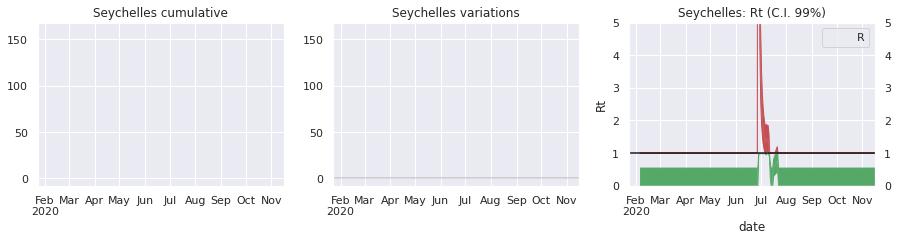

***

## Sierra Leone

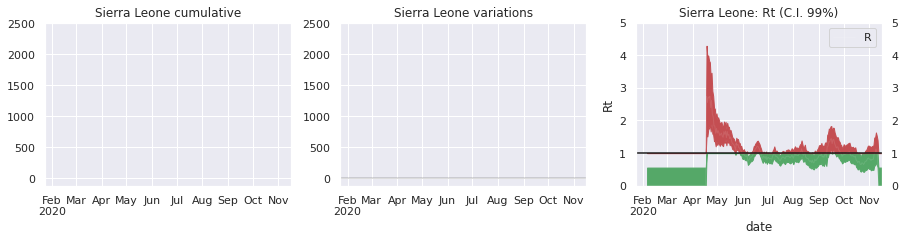

***

## Singapore

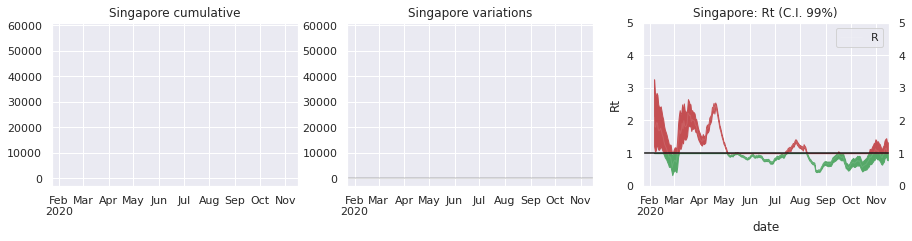

***

## Slovakia

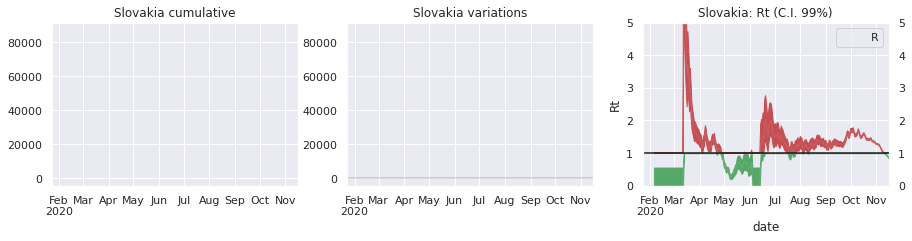

***

## Slovenia

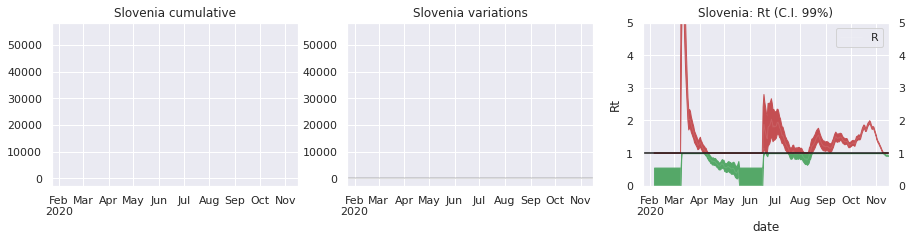

***

## Solomon Islands

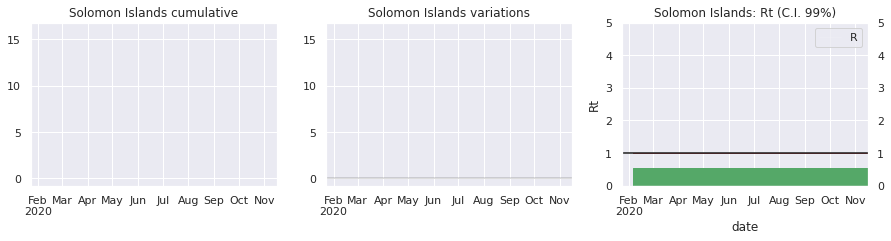

***

## Somalia

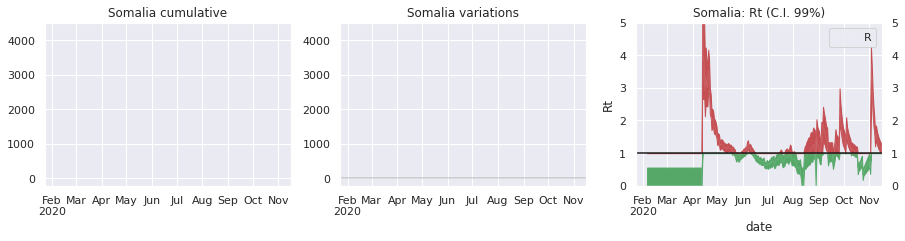

***

## South Africa

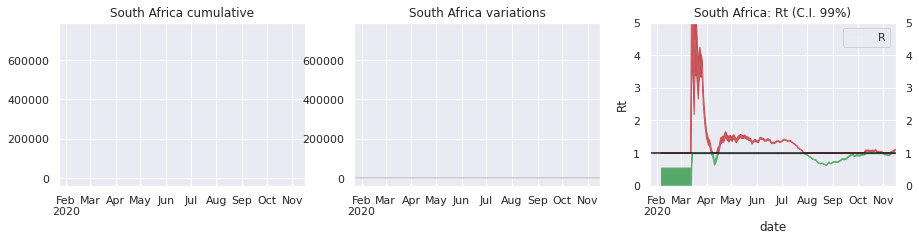

***

## South Sudan

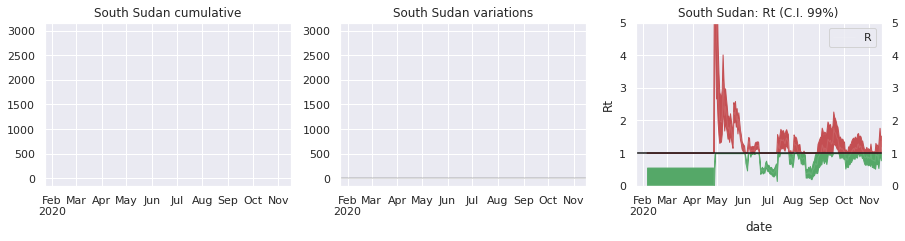

***

## Spain

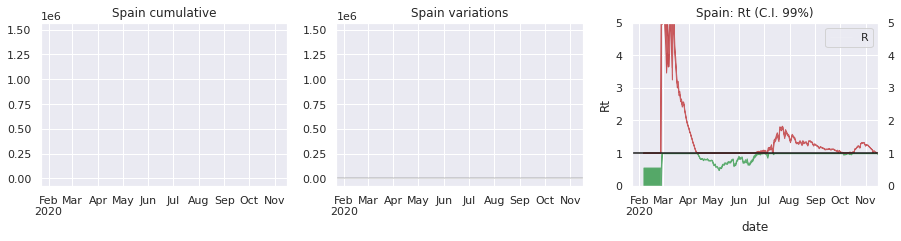

***

## Sri Lanka

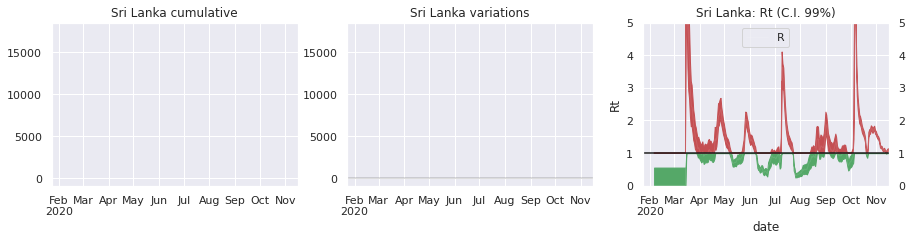

***

## Sudan

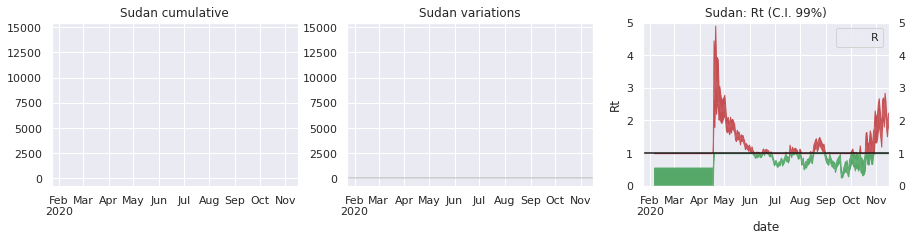

***

## Suriname

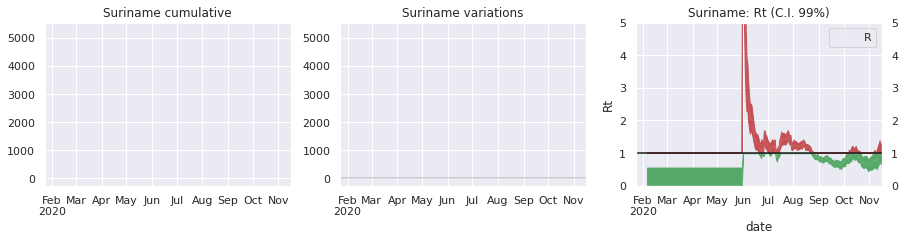

***

## Sweden

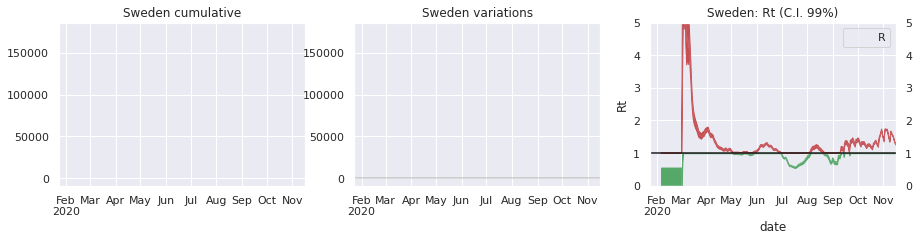

***

## Switzerland

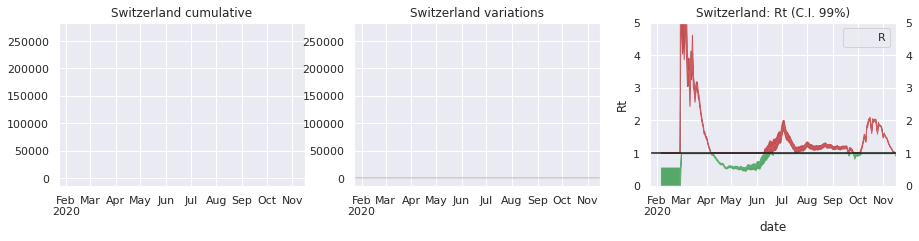

***

## Syria

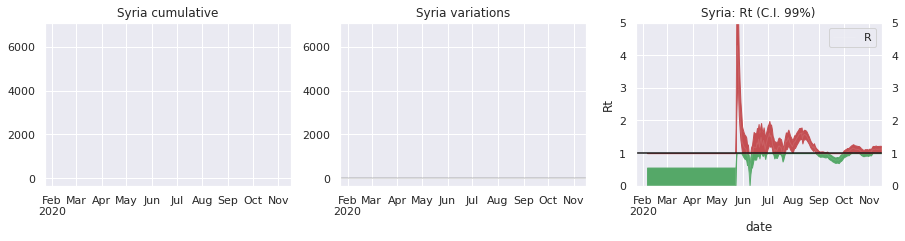

***

## Taiwan*

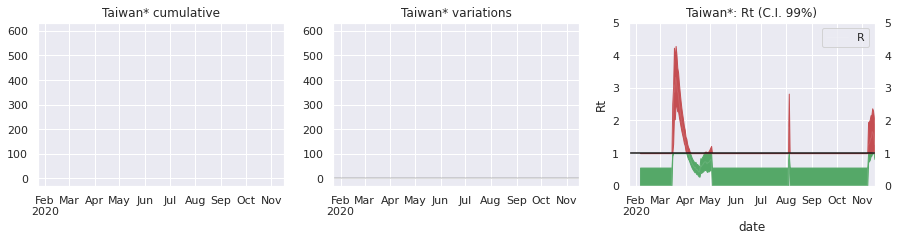

***

## Tajikistan

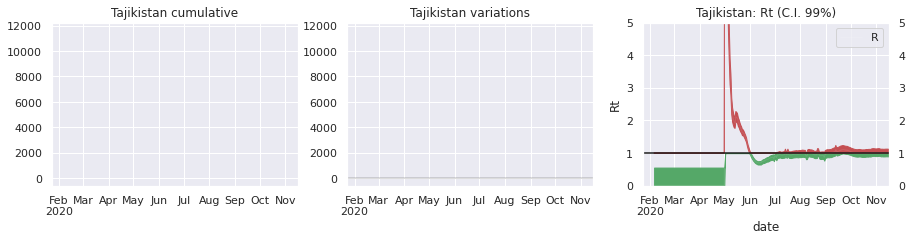

***

## Tanzania

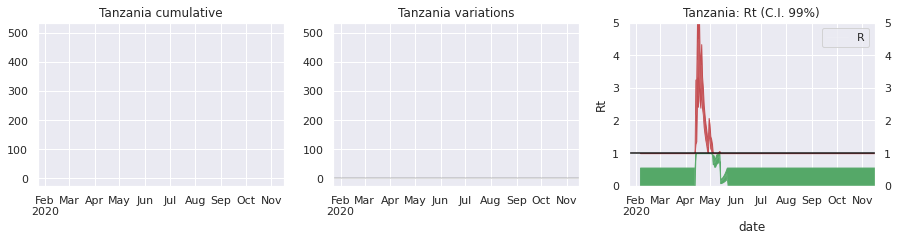

***

## Thailand

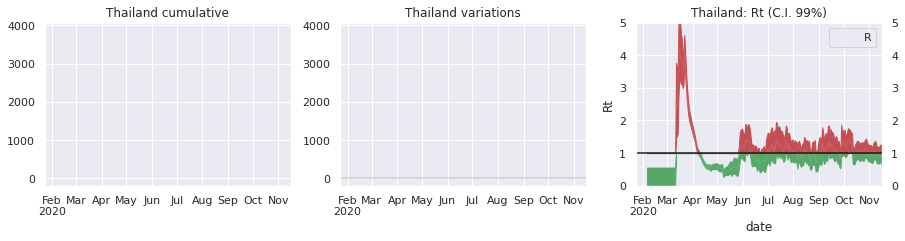

***

## Timor-Leste

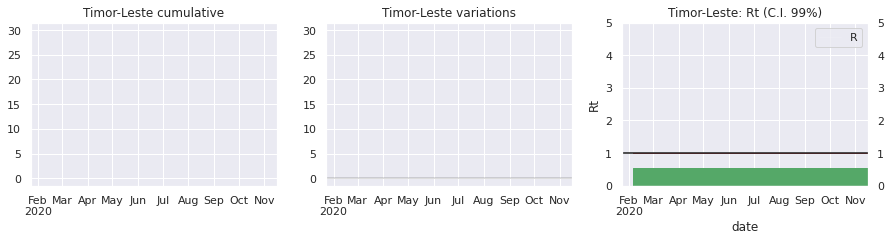

***

## Togo

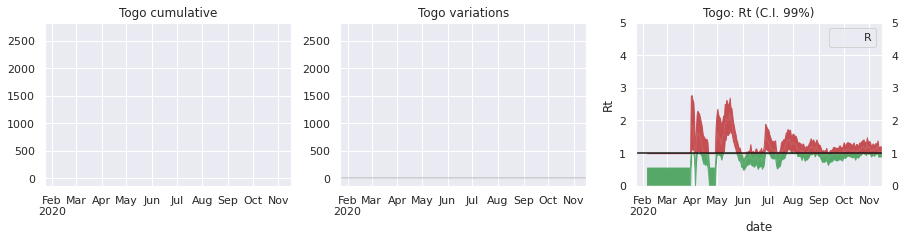

***

## Trinidad and Tobago

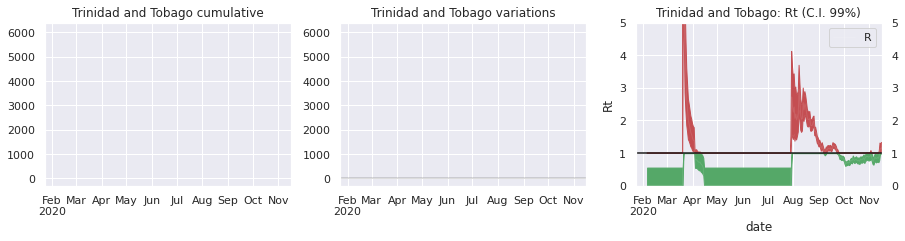

***

## Tunisia

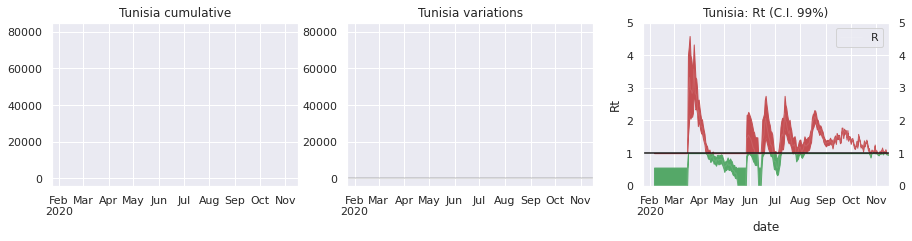

***

## Turkey

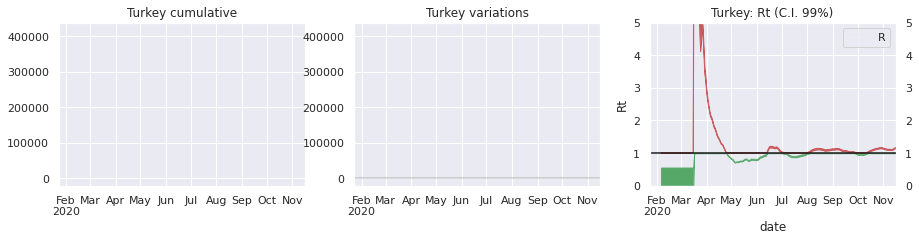

***

## US

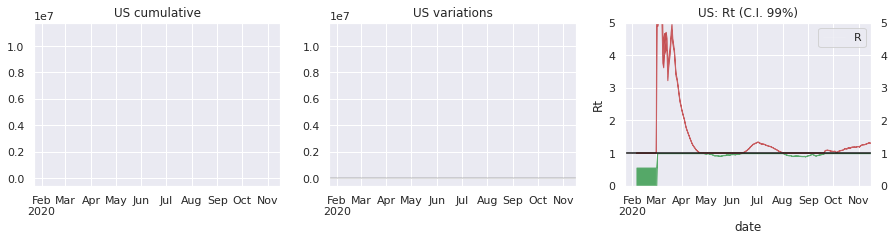

***

## Uganda

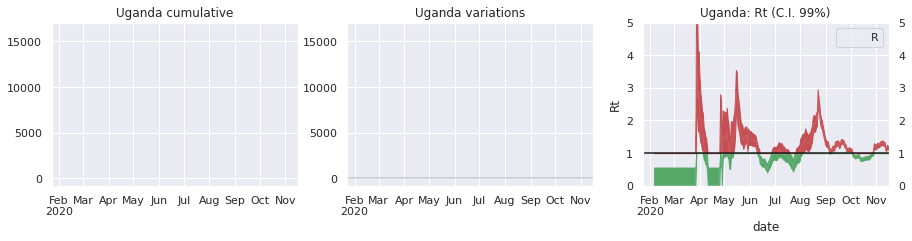

***

## Ukraine

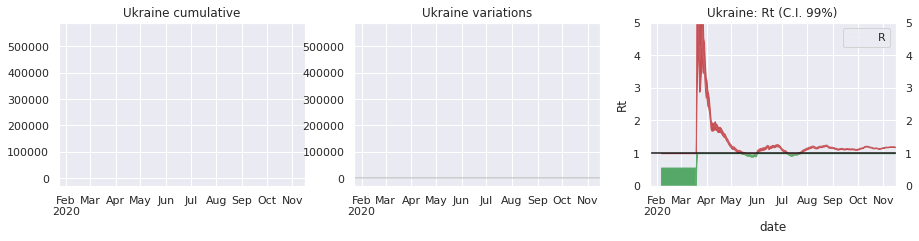

***

## United Arab Emirates

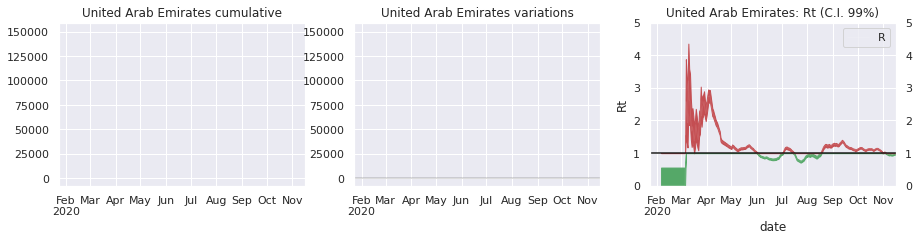

***

## United Kingdom

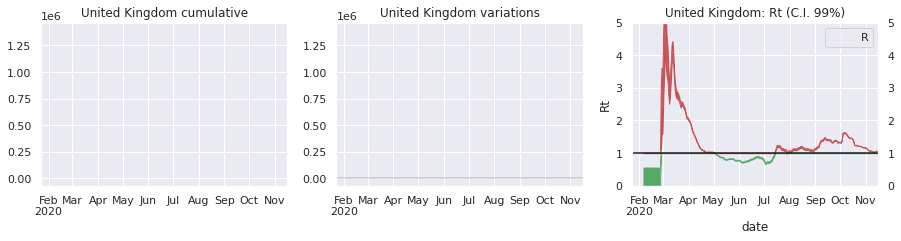

***

## Uruguay

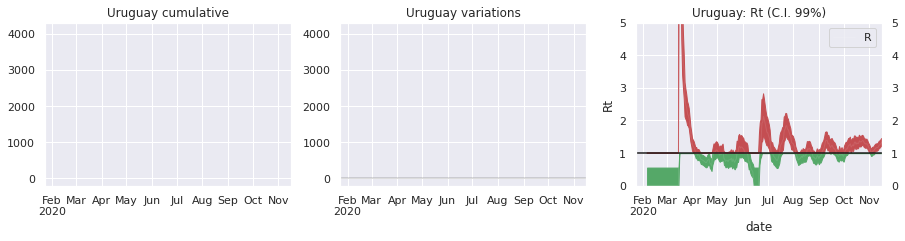

***

## Uzbekistan

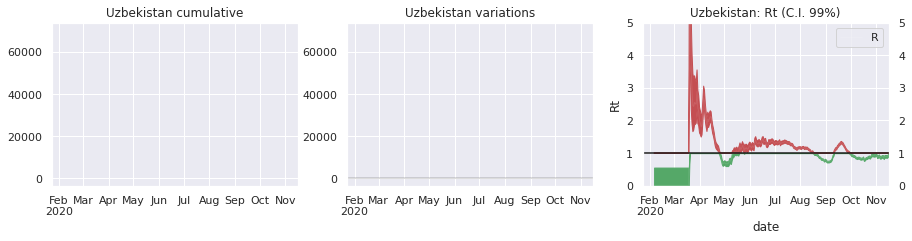

***

## Vanuatu

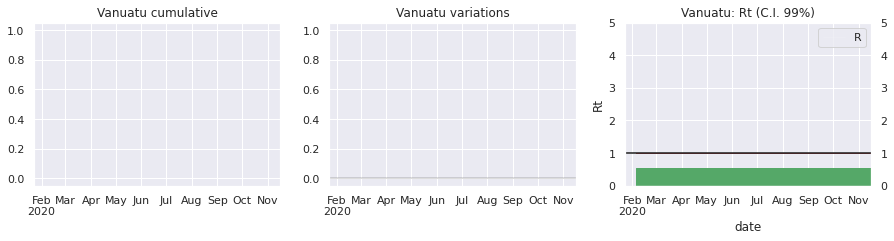

***

## Venezuela

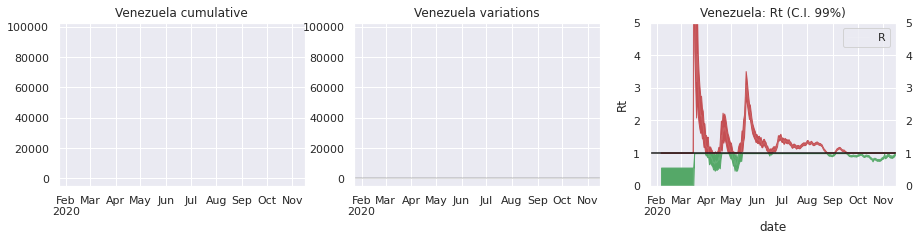

***

## Vietnam

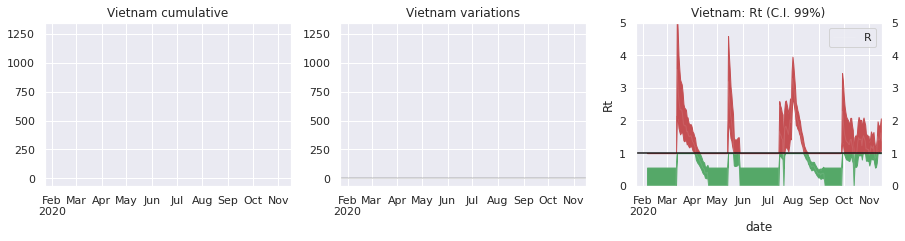

***

## West Bank and Gaza

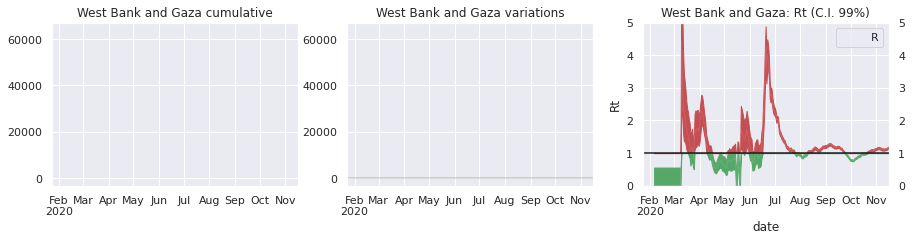

***

## Western Sahara

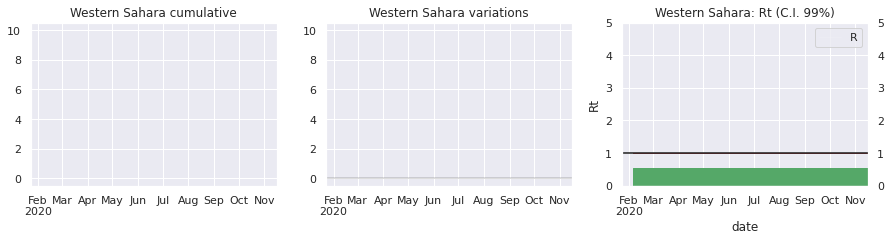

***

## Yemen

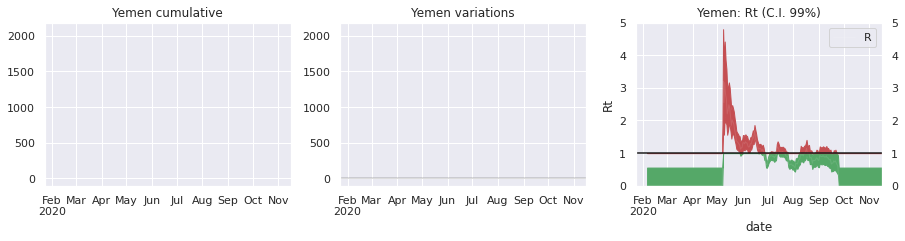

***

## Zambia

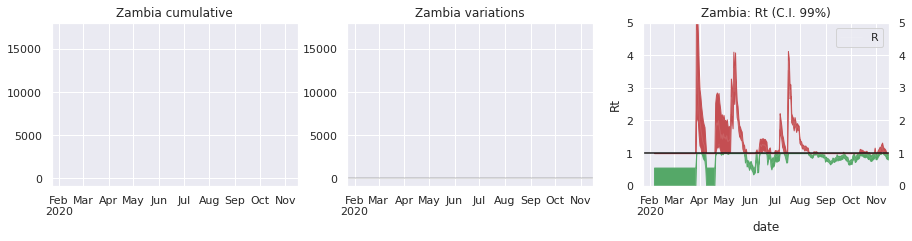

***

## Zimbabwe

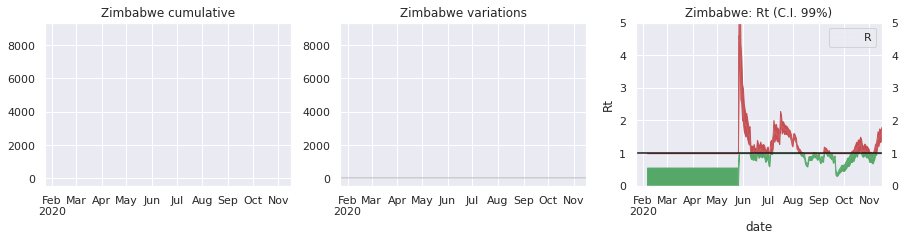

***

In [7]:
start = dt.datetime.now()

for country in countries:
    display(Markdown(f"## {country}"))
    fig, ax = plt.subplots(1, 3, figsize=(15, 3), sharex=True)
    
    t = T[country]
    if isinstance(t, pd.DataFrame):
        t = t.sum(axis=1)
    d = D[country]
    if isinstance(d, pd.DataFrame):
        d = d.sum(axis=1)
    r = R[country]
    if isinstance(r, pd.DataFrame):
        r = r.sum(axis=1)
    p = t - r - d

    # cumulativi
    ax[0].plot(days, t, c="k", lw=1)
    ax[0].fill_between(days, 0, p, color='blue')
    ax[0].fill_between(days, p, p+r, color='#00ff00')
    ax[0].fill_between(days, p+r, p+r+d, color='red')
    ax[0].set_title(f"{country} cumulative")
    #ax[0].grid()
    
    # mobilità
    _ = """
    g_country = country
    if country == "US":
        g_country = "United States"
        
    _df = google.loc[google["country_region"] == g_country]
    _df = _df.loc[_df.fillna("NONE")["sub_region_1"] == "NONE"]
    
    for column in _df.columns[4:]:
        ax[1,1].plot(
            _df.index, _df[column],
            label=column.replace("_", " ").title().split(" Percent")[0]
        )
    #ax[1,1].legend()
    ax[1,1].axhline(0, c='k', alpha=.2)
    ax[1,1].set_title(f"{country} mobility")
    ax[1,1].grid()
    """
    
    # variazioni
    ax[1].plot(days, t, 'k')
    ax[1].plot(days, r, 'g')
    ax[1].plot(days, d, 'r')
    ax[1].plot(days, p, 'b')
    
    ax[1].axhline(0, c='k', alpha=.2)
    ax[1].set_title(f"{country} variations")
    #ax[1].grid()
    
    incidence = t.diff()
    incidence[incidence<0] = 0
    
    _ = epi_estim_Rt(incidence[1:],
                    SI_sh=SI_sh_ISS,
                    SI_ra=SI_ra_ISS,
                    ax=ax[2],
                    title=country)
    
    fig.set_facecolor('w'); plt.show();
    plt.close(fig='all')
    display(Markdown("***"))

end = dt.datetime.now()

In [8]:
print(f"COMPLETED IN {end-start}")

COMPLETED IN 0:09:26.910196
